<a href="https://colab.research.google.com/github/wiv33/A-Learning-python/blob/master/machine-learning/_000_hello_machine/_000_basic/_003_cuk_edu/_005_3_computer_vision/11_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

실습 파일: `11-gan.ipynb`

**모델 및 소스코드 참고**  

David Foster저 Generative Deep Learning (O'REILLY출판, 2019)


# Autoencoder

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten
from tensorflow.keras.layers import Dense, Conv2DTranspose
from tensorflow.keras.layers import Reshape, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

import os

SAVE_FOLDER = 'data'

if not os.path.exists(SAVE_FOLDER):
    os.mkdir(SAVE_FOLDER)
    os.mkdir(os.path.join(SAVE_FOLDER, 'weights'))

In [2]:

MODE =  'build' #'load' #
#MODE =  'load'

**Encoder 모델 정의**

In [3]:
z_dim = 2

encoder_input = keras.Input(shape=(28, 28, 1), name='encoder_input')
x = Conv2D(32, 3, strides=1, padding="same", name='encoder_conv_0')(encoder_input)
x = LeakyReLU()(x)
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_1')(x)
x = LeakyReLU()(x)
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_2')(x)
x = LeakyReLU()(x)
x = Conv2D(64, 3, strides=1, padding="same", name='encoder_conv_3')(x)
x = LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]
x = Flatten()(x)
encoder_output= Dense(z_dim, name='encoder_output')(x)
encoder = keras.Model(encoder_input, encoder_output, name='encoder')

In [4]:
decoder_input = keras.Input(shape=(z_dim,), name='decoder_input')
x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(64, 3, strides=1, padding="same", name='decoder_conv_t0')(x)
x = LeakyReLU()(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", name='decoder_conv_t1')(x)
x = LeakyReLU()(x)
x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", name='decoder_conv_t2')(x)
x = LeakyReLU()(x)
x = layers.Conv2DTranspose(1, 3, strides=1, padding="same", name='decoder_conv_t3')(x)
decoder_output = Activation('sigmoid')(x)
decoder = keras.Model(decoder_input, decoder_output, name="decoder")

In [5]:
encoder.summary()
decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder_conv_0 (Conv2D)     (None, 28, 28, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 14, 14, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 encoder_conv_2 (Conv2D)     (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 7, 7, 64)          0   

In [6]:
class AutoEncoder(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(AutoEncoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
    def call(self,inputs):
        latent = self.encoder(inputs)
        return self.decoder(latent)

@tf.function
def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

LEARNING_RATE = 0.0005
BATCH_SIZE = 32
INITIAL_EPOCH = 0
EPOCHS = 200

In [7]:
save_folder = os.path.join(SAVE_FOLDER, 'weights')

ae = AutoEncoder(encoder, decoder)
ae.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss=r_loss)

if MODE == 'build':
    x = np.random.rand(1,28,28,1)
    ae.predict(x)
    ae.save(save_folder)
else:
    ae = keras.models.load_model(save_folder, custom_objects={'r_loss': r_loss})
    #ae.load_weights(save_folder+'/'+'checkpoint')

INFO:tensorflow:Assets written to: data/weights/assets


INFO:tensorflow:Assets written to: data/weights/assets


**학습하기**

In [8]:
# mnist 데이터 읽어오기
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
#mnist_digits = np.concatenate([x_train, x_test], axis=0)
#mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

x_train = x_train.reshape((60000, 28, 28, 1))
x_test = x_test.reshape((10000, 28, 28, 1))

x_train = x_train/255.
x_test = x_test/255.

# 매 epoch마다 모델 weights 저장
#lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=1)
checkpoint = ModelCheckpoint(save_folder+'/'+'checkpoint', save_weights_only = False, verbose=1)

#callbacks_list = [checkpoint]
callbacks_list = []
ae.fit(x_train[:1000], x_train[:1000], epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks_list)
ae.save(save_folder)

11501568/11490434 [==============================] - 0s 0us/step
Epoch 1/200
32/32 [==============================] - 2s 12ms/step - loss: 0.1808
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.1085
Epoch 3/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0911
Epoch 4/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0684
Epoch 5/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0638
Epoch 6/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0607
Epoch 7/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0593
Epoch 8/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0579
Epoch 9/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0566
Epoch 10/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0555
Epoch 11/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0545
Epoch 12/200
32/32 [==============================] 

INFO:tensorflow:Assets written to: data/weights/assets


**모델 읽어들이기**

In [9]:

save_folder = os.path.join(SAVE_FOLDER, 'weights')
#AE = AutoEncoder(encoder, decoder)
#AE.load_weights(save_folder+'/'+'checkpoint')
AE = keras.models.load_model(save_folder, custom_objects={'r_loss': r_loss})


**생성해 보기**

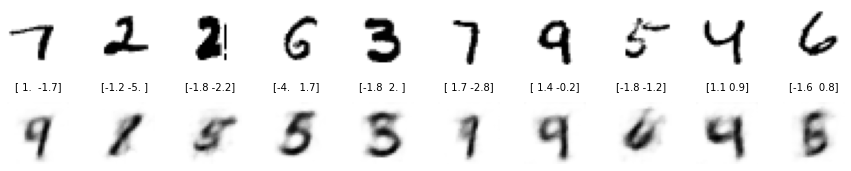

In [10]:
import matplotlib.pyplot as plt

n_to_show = 10
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

z_points = AE.encoder.predict(example_images)

reconst_images = ae.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)   
    ax.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')


**Latent space의 분포**

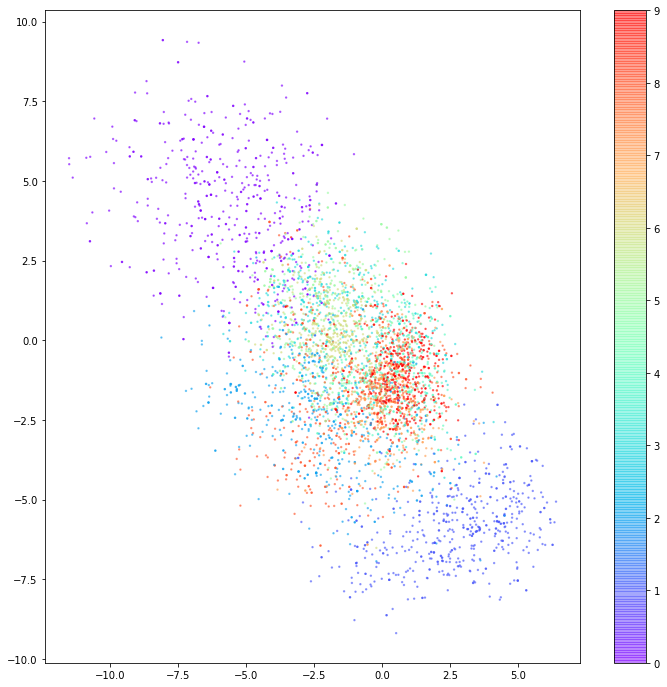

In [11]:
n_to_show = 5000
grid_size = 15
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = AE.encoder.predict(example_images)

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()
plt.show()

**Latent space에서 일정 간격으로 latent vector를 추출하여 생성된 결과**

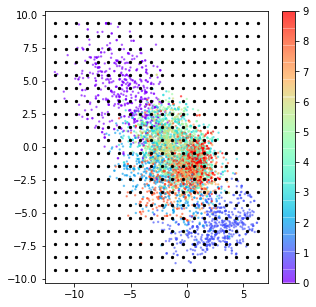

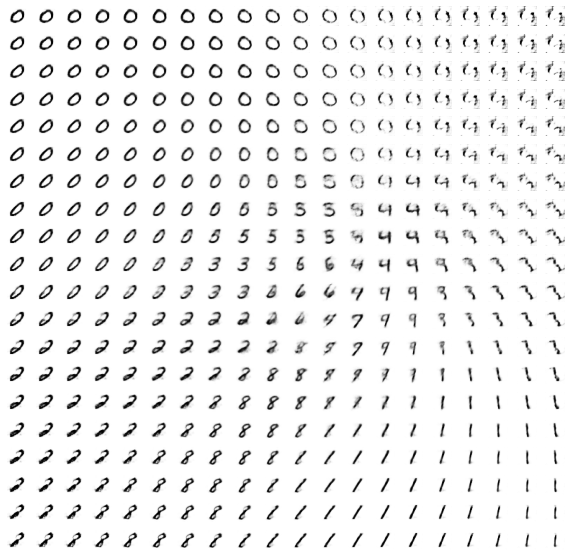

In [12]:
n_to_show = 5000
grid_size = 20
figsize = 10

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = AE.encoder.predict(example_images)

plt.figure(figsize=(5, 5))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()

# x = norm.ppf(np.linspace(0.05, 0.95, 10))
# y = norm.ppf(np.linspace(0.05, 0.95, 10))
x = np.linspace(min(z_points[:, 0]), max(z_points[:, 0]), grid_size)
y = np.linspace(max(z_points[:, 1]), min(z_points[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

reconst = AE.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
            , alpha=1, s=5)
plt.show()


fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

# GAN

In [13]:
!mkdir -p gan_data/motorbike
!mkdir -p gan_data/images
!mkdir -p gan_data/weights
!gdown --id 1xBCbjopxZCvzzTMuRKKaTpF-i2jLz7xa -O gan_data/motorbike/full_numpy_bitmap_motorbike.npy


/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1xBCbjopxZCvzzTMuRKKaTpF-i2jLz7xa
To: /content/gan_data/motorbike/full_numpy_bitmap_motorbike.npy
100% 133M/133M [00:01<00:00, 96.2MB/s]


In [14]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, ReLU, Flatten
from tensorflow.keras.layers import Dense, Conv2DTranspose
from tensorflow.keras.layers import Reshape, Activation
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import Input, UpSampling2D
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
import os
from os import walk
import matplotlib.pyplot as plt
import matplotlib.image as mp_image

**Quick! Draw! database**  
Dataset 홈페이지:  https://quickdraw.withgoogle.com/data  
Motorbike numpy 다운로드: https://console.cloud.google.com/storage/browser/_details/quickdraw_dataset/full/numpy_bitmap/motorbike.npy  

Quick & Draw 참여 페이지  
https://quickdraw.withgoogle.com/  


In [16]:
SAVE_FOLDER = 'gan_data'

def load_quickdraw(folder):

    mypath = os.path.join(SAVE_FOLDER, folder)
    txt_name_list = []
    for (dirpath, dirnames, filenames) in walk(mypath):
        for f in filenames:
            if f != '.DS_Store':
                txt_name_list.append(f)
                break

    slice_train = int(80000/len(txt_name_list))  ###Setting value to be 80000 for the final dataset
    i = 0
    seed = np.random.randint(1, 10e6)

    for txt_name in txt_name_list:
        txt_path = os.path.join(mypath,txt_name)
        x = np.load(txt_path)
        x = (x.astype('float32') - 127.5) / 127.5
        # x = x.astype('float32') / 255.0

        x = x.reshape(x.shape[0], 28, 28, 1)

        y = [i] * len(x)
        np.random.seed(seed)
        np.random.shuffle(x)
        np.random.seed(seed)
        np.random.shuffle(y)
        x = x[:slice_train]
        y = y[:slice_train]
        if i != 0:
            xtotal = np.concatenate((x,xtotal), axis=0)
            ytotal = np.concatenate((y,ytotal), axis=0)
        else:
            xtotal = x
            ytotal = y
        i += 1

    return xtotal, ytotal

In [17]:
x_train, y_train = load_quickdraw('motorbike')

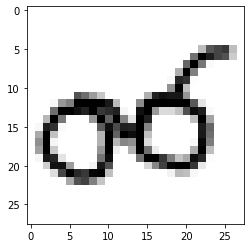

In [18]:
plt.imshow(x_train[501,:,:,0], cmap = 'binary')
plt.show()

입력 이미지 사이즈: (28,28)

In [19]:
input_dim = (28,28,1)
weight_init = RandomNormal(mean=0., stddev=0.02)

**Discriminator 모델 정의**

In [20]:
discriminator_input = keras.Input(shape=input_dim, name='discriminator_input')
x = Conv2D(64, 5, strides=2, padding="same",
      kernel_initializer=weight_init, name='discriminator_conv_0')(discriminator_input)
x = ReLU()(x)
x = Dropout(rate = 0.4)(x)
x = Conv2D(64, 5, strides=2, padding="same",
    kernel_initializer=weight_init, name='discriminator_conv_1')(x)
x = ReLU()(x)
x = Dropout(rate = 0.4)(x)
x = Conv2D(128, 5, strides=2, padding="same",
      kernel_initializer=weight_init, name='discriminator_conv_2')(x)
x = ReLU()(x)
x = Dropout(rate = 0.4)(x)
x = Conv2D(128, 5, strides=1, padding="same",
      kernel_initializer=weight_init, name='discriminator_conv_3')(x)
x = ReLU()(x)
x = Dropout(rate = 0.4)(x)
x = Flatten()(x)
discriminator_output = Dense(1, activation='sigmoid',
    kernel_initializer = RandomNormal(mean=0., stddev=0.02))(x)
discriminator = keras.Model(discriminator_input, discriminator_output, name = 'discriminator')
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 discriminator_input (InputL  [(None, 28, 28, 1)]      0         
 ayer)                                                           
                                                                 
 discriminator_conv_0 (Conv2  (None, 14, 14, 64)       1664      
 D)                                                              
                                                                 
 re_lu (ReLU)                (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 discriminator_conv_1 (Conv2  (None, 7, 7, 64)         102464    
 D)                                                              
                                                     

**Generator 모델 정의**

In [21]:
z_dim = 100

generator_input = keras.Input(shape=(z_dim,), name='generator_input')
x = Dense(np.prod((7, 7, 64)), kernel_initializer = RandomNormal(mean=0., stddev=0.02))(generator_input)
x = BatchNormalization(momentum=0.9)(x)
x = ReLU()(x)
x = Reshape((7,7,64))(x)
x = UpSampling2D()(x)
x = Conv2D(128, 5, padding="same", kernel_initializer=weight_init, name='generator_conv_0')(x)
x = BatchNormalization(momentum=0.9)(x)
x = ReLU()(x)
x = UpSampling2D()(x)
x = Conv2D(64, 5, padding="same", kernel_initializer=weight_init, name='generator_conv_1')(x)
x = BatchNormalization(momentum=0.9)(x)
x = ReLU()(x)
x = Conv2DTranspose(64, 5, strides=1, padding="same", kernel_initializer=weight_init, name='generator_conv_2')(x)
x = BatchNormalization(momentum=0.9)(x)
x = ReLU()(x)
x = Conv2DTranspose(1, 5, strides=1, padding="same", kernel_initializer=weight_init, name='generator_conv_3')(x)
generator_output = Activation('tanh')(x) # -1 ~ 1
generator = keras.Model(generator_input, generator_output, name="generator")
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_input (InputLayer  [(None, 100)]            0         
 )                                                               
                                                                 
 dense_2 (Dense)             (None, 3136)              316736    
                                                                 
 batch_normalization (BatchN  (None, 3136)             12544     
 ormalization)                                                   
                                                                 
 re_lu_4 (ReLU)              (None, 3136)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 64)       0 

Discriminator를 먼저 컴파일

In [23]:
### COMPILE DISCRIMINATOR

discriminator.compile(
  optimizer=RMSprop(lr=0.0008),
  loss = 'binary_crossentropy',
  metrics = ['accuracy']
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Discriminator를 freeze하고, generator와 연결하여  
model을 정의  
Generator용 모델 컴파일  

In [24]:
### COMPILE THE FULL GAN

def set_trainable(m, val):
    m.trainable = val
    for l in m.layers:
        l.trainable = val

# 먼저discriminator를 훈련 불가능 상태로 만듬.
set_trainable(discriminator, False)

model_input = Input(shape=(z_dim,), name='model_input')
model_output = discriminator(generator(model_input))
model = Model(model_input, model_output)

model.compile(optimizer=RMSprop(learning_rate=0.0004) , loss='binary_crossentropy', metrics=['accuracy']
  , experimental_run_tf_function=False
)

# compile이 완료되었으므로, discriminator를 훈련 가능 상태로 복귀.
set_trainable(discriminator, True)

최초 실행시에는 `build`를 사용  
저장된 weights를 loading해서 계속할 때에는 `load`사용

In [25]:
mode = 'build'
#mode = 'load'

if mode == 'build':
    model.save(SAVE_FOLDER)
else:
    model.load_weights(os.path.join(SAVE_FOLDER, 'weights/weights.h5'))

INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


d,g의 loss 및 accuracy를 저장해 두는 변수

In [26]:
total_epoch = 0
d_losses = []
g_losses = []

**GAN 학습**

In [27]:
def train_discriminator(x_train, batch_size):

    valid = np.ones((batch_size,1))
    fake = np.zeros((batch_size,1))

    idx = np.random.randint(0, x_train.shape[0], batch_size)
    true_imgs = x_train[idx]

    noise = np.random.normal(0, 1, (batch_size, z_dim))
    gen_imgs = generator.predict(noise)

    d_loss_real, d_acc_real =   discriminator.train_on_batch(true_imgs, valid)
    d_loss_fake, d_acc_fake =   discriminator.train_on_batch(gen_imgs, fake)
    d_loss =  0.5 * (d_loss_real + d_loss_fake)
    d_acc = 0.5 * (d_acc_real + d_acc_fake)

    return [d_loss, d_loss_real, d_loss_fake, d_acc, d_acc_real, d_acc_fake]

def train_generator(batch_size):
    valid = np.ones((batch_size,1))
    noise = np.random.normal(0, 1, (batch_size, z_dim))
    return model.train_on_batch(noise, valid)



# 중간 epoch에서 생성 이미지를 샘플링하여 저장해두기 위한 함수
def sample_images(run_folder):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, z_dim))
    gen_imgs = generator.predict(noise)

    gen_imgs = 0.5 * (gen_imgs + 1)
    gen_imgs = np.clip(gen_imgs, 0, 1)

    fig, axs = plt.subplots(r, c, figsize=(15,15))
    cnt = 0

    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig(os.path.join(run_folder, "images/sample_%d.png" % total_epoch))
    plt.close()

# discriminator와 generator를 번갈아가며, 학습
def train(x_train, batch_size, epochs, run_folder,
          print_every_n_batches = 50,
          ):

    global total_epoch
    for epoch in range(total_epoch, total_epoch + epochs):

        d = train_discriminator(x_train, batch_size)
        g = train_generator(batch_size)

        print ("%d [D loss: (%.3f)(R %.3f, F %.3f)] [D acc: (%.3f)(%.3f, %.3f)] [G loss: %.3f] [G acc: %.3f]" % (epoch, d[0], d[1], d[2], d[3], d[4], d[5], g[0], g[1]))

        d_losses.append(d)
        g_losses.append(g)

        if epoch % print_every_n_batches == 0:
            sample_images(run_folder)
            #model.save_weights(os.path.join(run_folder, 'weights/weights-%d.h5' % (epoch)))
            model.save_weights(os.path.join(run_folder, 'weights/weights.h5'))
            model.save(run_folder)

        total_epoch += 1


In [28]:
BATCH_SIZE = 64
EPOCHS = 2000
PRINT_EVERY_N_BATCHES = 20

train(
    x_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    run_folder = SAVE_FOLDER,
    print_every_n_batches = PRINT_EVERY_N_BATCHES,
)

0 [D loss: (0.724)(R 0.697, F 0.752)] [D acc: (0.164)(0.328, 0.000)] [G loss: 0.685] [G acc: 1.000]
INFO:tensorflow:Assets written to: gan_data/assets


INFO:tensorflow:Assets written to: gan_data/assets


1 [D loss: (0.698)(R 0.672, F 0.724)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.672] [G acc: 1.000]
2 [D loss: (1.470)(R 0.587, F 2.353)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.656] [G acc: 1.000]
3 [D loss: (0.662)(R 0.624, F 0.699)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.630] [G acc: 1.000]
4 [D loss: (0.647)(R 0.594, F 0.700)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.581] [G acc: 1.000]
5 [D loss: (0.626)(R 0.544, F 0.708)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.462] [G acc: 1.000]
6 [D loss: (0.646)(R 0.431, F 0.861)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.402] [G acc: 1.000]
7 [D loss: (0.626)(R 0.378, F 0.874)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.342] [G acc: 1.000]
8 [D loss: (0.798)(R 0.340, F 1.255)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.570] [G acc: 1.000]
9 [D loss: (0.678)(R 0.523, F 0.833)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.595] [G acc: 1.000]
10 [D loss: (0.679)(R 0.517, F 0.842)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.627] [G acc: 1.000]

INFO:tensorflow:Assets written to: gan_data/assets


21 [D loss: (0.213)(R 0.193, F 0.234)] [D acc: (0.992)(0.984, 1.000)] [G loss: 0.054] [G acc: 1.000]
22 [D loss: (0.194)(R 0.191, F 0.198)] [D acc: (0.969)(0.969, 0.969)] [G loss: 0.031] [G acc: 1.000]
23 [D loss: (0.111)(R 0.108, F 0.115)] [D acc: (0.961)(0.969, 0.953)] [G loss: 0.018] [G acc: 1.000]
24 [D loss: (0.127)(R 0.081, F 0.173)] [D acc: (0.961)(1.000, 0.922)] [G loss: 0.015] [G acc: 1.000]
25 [D loss: (0.259)(R 0.174, F 0.343)] [D acc: (0.914)(0.969, 0.859)] [G loss: 0.013] [G acc: 1.000]
26 [D loss: (0.355)(R 0.102, F 0.608)] [D acc: (0.852)(0.984, 0.719)] [G loss: 0.048] [G acc: 1.000]
27 [D loss: (1.022)(R 0.547, F 1.496)] [D acc: (0.523)(0.781, 0.266)] [G loss: 0.118] [G acc: 1.000]
28 [D loss: (0.597)(R 0.344, F 0.850)] [D acc: (0.703)(0.953, 0.453)] [G loss: 0.133] [G acc: 1.000]
29 [D loss: (0.675)(R 0.393, F 0.958)] [D acc: (0.641)(0.938, 0.344)] [G loss: 0.192] [G acc: 1.000]
30 [D loss: (0.744)(R 0.582, F 0.907)] [D acc: (0.555)(0.766, 0.344)] [G loss: 0.246] [G ac

INFO:tensorflow:Assets written to: gan_data/assets


41 [D loss: (0.693)(R 0.674, F 0.712)] [D acc: (0.523)(0.625, 0.422)] [G loss: 0.856] [G acc: 0.000]
42 [D loss: (0.675)(R 0.669, F 0.682)] [D acc: (0.609)(0.734, 0.484)] [G loss: 0.749] [G acc: 0.078]
43 [D loss: (0.551)(R 0.680, F 0.422)] [D acc: (0.773)(0.672, 0.875)] [G loss: 0.559] [G acc: 0.922]
44 [D loss: (1.083)(R 0.582, F 1.583)] [D acc: (0.422)(0.844, 0.000)] [G loss: 0.737] [G acc: 0.062]
45 [D loss: (0.701)(R 0.711, F 0.692)] [D acc: (0.406)(0.219, 0.594)] [G loss: 0.719] [G acc: 0.078]
46 [D loss: (0.689)(R 0.691, F 0.688)] [D acc: (0.586)(0.531, 0.641)] [G loss: 0.724] [G acc: 0.016]
47 [D loss: (0.683)(R 0.678, F 0.688)] [D acc: (0.625)(0.641, 0.609)] [G loss: 0.729] [G acc: 0.062]
48 [D loss: (0.677)(R 0.655, F 0.699)] [D acc: (0.641)(0.797, 0.484)] [G loss: 0.798] [G acc: 0.000]
49 [D loss: (0.680)(R 0.649, F 0.710)] [D acc: (0.641)(0.766, 0.516)] [G loss: 0.743] [G acc: 0.094]
50 [D loss: (0.693)(R 0.637, F 0.750)] [D acc: (0.578)(0.734, 0.422)] [G loss: 0.732] [G ac

INFO:tensorflow:Assets written to: gan_data/assets


61 [D loss: (0.685)(R 0.661, F 0.708)] [D acc: (0.539)(0.797, 0.281)] [G loss: 0.716] [G acc: 0.266]
62 [D loss: (0.691)(R 0.666, F 0.717)] [D acc: (0.500)(0.781, 0.219)] [G loss: 0.725] [G acc: 0.062]
63 [D loss: (0.680)(R 0.652, F 0.709)] [D acc: (0.625)(0.906, 0.344)] [G loss: 0.744] [G acc: 0.000]
64 [D loss: (0.694)(R 0.663, F 0.726)] [D acc: (0.461)(0.750, 0.172)] [G loss: 0.717] [G acc: 0.141]
65 [D loss: (0.681)(R 0.654, F 0.708)] [D acc: (0.602)(0.844, 0.359)] [G loss: 0.733] [G acc: 0.016]
66 [D loss: (0.682)(R 0.653, F 0.711)] [D acc: (0.570)(0.766, 0.375)] [G loss: 0.725] [G acc: 0.188]
67 [D loss: (0.708)(R 0.642, F 0.774)] [D acc: (0.461)(0.859, 0.062)] [G loss: 0.725] [G acc: 0.031]
68 [D loss: (0.680)(R 0.654, F 0.706)] [D acc: (0.555)(0.781, 0.328)] [G loss: 0.723] [G acc: 0.062]
69 [D loss: (0.688)(R 0.639, F 0.738)] [D acc: (0.469)(0.828, 0.109)] [G loss: 0.712] [G acc: 0.156]
70 [D loss: (0.688)(R 0.619, F 0.757)] [D acc: (0.516)(0.953, 0.078)] [G loss: 0.712] [G ac

INFO:tensorflow:Assets written to: gan_data/assets


81 [D loss: (0.668)(R 0.579, F 0.757)] [D acc: (0.539)(0.922, 0.156)] [G loss: 0.720] [G acc: 0.062]
82 [D loss: (0.645)(R 0.517, F 0.773)] [D acc: (0.625)(0.984, 0.266)] [G loss: 0.764] [G acc: 0.047]
83 [D loss: (0.625)(R 0.554, F 0.696)] [D acc: (0.711)(0.844, 0.578)] [G loss: 0.812] [G acc: 0.000]
84 [D loss: (0.992)(R 0.502, F 1.482)] [D acc: (0.461)(0.906, 0.016)] [G loss: 0.732] [G acc: 0.047]
85 [D loss: (0.640)(R 0.604, F 0.675)] [D acc: (0.773)(0.766, 0.781)] [G loss: 0.720] [G acc: 0.188]
86 [D loss: (0.679)(R 0.547, F 0.811)] [D acc: (0.539)(0.906, 0.172)] [G loss: 0.712] [G acc: 0.172]
87 [D loss: (0.790)(R 0.584, F 0.995)] [D acc: (0.414)(0.812, 0.016)] [G loss: 0.687] [G acc: 0.500]
88 [D loss: (0.776)(R 0.632, F 0.921)] [D acc: (0.375)(0.734, 0.016)] [G loss: 0.647] [G acc: 0.781]
89 [D loss: (0.788)(R 0.667, F 0.909)] [D acc: (0.328)(0.641, 0.016)] [G loss: 0.733] [G acc: 0.281]
90 [D loss: (0.714)(R 0.693, F 0.736)] [D acc: (0.320)(0.422, 0.219)] [G loss: 0.742] [G ac

INFO:tensorflow:Assets written to: gan_data/assets


101 [D loss: (0.720)(R 0.698, F 0.741)] [D acc: (0.344)(0.531, 0.156)] [G loss: 0.788] [G acc: 0.000]
102 [D loss: (0.700)(R 0.701, F 0.699)] [D acc: (0.422)(0.344, 0.500)] [G loss: 0.703] [G acc: 0.203]
103 [D loss: (0.690)(R 0.685, F 0.695)] [D acc: (0.555)(0.531, 0.578)] [G loss: 0.705] [G acc: 0.109]
104 [D loss: (0.694)(R 0.689, F 0.700)] [D acc: (0.508)(0.562, 0.453)] [G loss: 0.709] [G acc: 0.062]
105 [D loss: (0.691)(R 0.687, F 0.696)] [D acc: (0.531)(0.562, 0.500)] [G loss: 0.697] [G acc: 0.375]
106 [D loss: (0.695)(R 0.687, F 0.702)] [D acc: (0.430)(0.469, 0.391)] [G loss: 0.697] [G acc: 0.344]
107 [D loss: (0.698)(R 0.697, F 0.699)] [D acc: (0.430)(0.359, 0.500)] [G loss: 0.701] [G acc: 0.266]
108 [D loss: (0.694)(R 0.694, F 0.694)] [D acc: (0.453)(0.375, 0.531)] [G loss: 0.703] [G acc: 0.188]
109 [D loss: (0.691)(R 0.688, F 0.693)] [D acc: (0.609)(0.531, 0.688)] [G loss: 0.704] [G acc: 0.109]
110 [D loss: (0.693)(R 0.690, F 0.696)] [D acc: (0.469)(0.422, 0.516)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


121 [D loss: (0.693)(R 0.682, F 0.704)] [D acc: (0.523)(0.625, 0.422)] [G loss: 0.710] [G acc: 0.047]
122 [D loss: (0.695)(R 0.689, F 0.701)] [D acc: (0.469)(0.484, 0.453)] [G loss: 0.710] [G acc: 0.031]
123 [D loss: (0.689)(R 0.686, F 0.692)] [D acc: (0.586)(0.594, 0.578)] [G loss: 0.708] [G acc: 0.016]
124 [D loss: (0.691)(R 0.680, F 0.702)] [D acc: (0.562)(0.625, 0.500)] [G loss: 0.708] [G acc: 0.078]
125 [D loss: (0.688)(R 0.686, F 0.691)] [D acc: (0.547)(0.500, 0.594)] [G loss: 0.714] [G acc: 0.031]
126 [D loss: (0.689)(R 0.678, F 0.700)] [D acc: (0.547)(0.641, 0.453)] [G loss: 0.712] [G acc: 0.109]
127 [D loss: (0.694)(R 0.676, F 0.712)] [D acc: (0.516)(0.719, 0.312)] [G loss: 0.713] [G acc: 0.016]
128 [D loss: (0.692)(R 0.681, F 0.703)] [D acc: (0.516)(0.594, 0.438)] [G loss: 0.710] [G acc: 0.047]
129 [D loss: (0.686)(R 0.669, F 0.703)] [D acc: (0.617)(0.766, 0.469)] [G loss: 0.709] [G acc: 0.062]
130 [D loss: (0.691)(R 0.669, F 0.713)] [D acc: (0.547)(0.719, 0.375)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


141 [D loss: (0.690)(R 0.670, F 0.711)] [D acc: (0.516)(0.641, 0.391)] [G loss: 0.715] [G acc: 0.172]
142 [D loss: (0.688)(R 0.668, F 0.708)] [D acc: (0.594)(0.688, 0.500)] [G loss: 0.708] [G acc: 0.219]
143 [D loss: (0.686)(R 0.671, F 0.701)] [D acc: (0.609)(0.703, 0.516)] [G loss: 0.706] [G acc: 0.266]
144 [D loss: (0.691)(R 0.655, F 0.726)] [D acc: (0.555)(0.750, 0.359)] [G loss: 0.712] [G acc: 0.156]
145 [D loss: (0.706)(R 0.652, F 0.760)] [D acc: (0.469)(0.719, 0.219)] [G loss: 0.707] [G acc: 0.234]
146 [D loss: (0.690)(R 0.666, F 0.715)] [D acc: (0.516)(0.641, 0.391)] [G loss: 0.703] [G acc: 0.219]
147 [D loss: (0.689)(R 0.663, F 0.715)] [D acc: (0.547)(0.719, 0.375)] [G loss: 0.712] [G acc: 0.156]
148 [D loss: (0.683)(R 0.664, F 0.702)] [D acc: (0.531)(0.594, 0.469)] [G loss: 0.720] [G acc: 0.078]
149 [D loss: (0.703)(R 0.665, F 0.740)] [D acc: (0.469)(0.641, 0.297)] [G loss: 0.708] [G acc: 0.156]
150 [D loss: (0.687)(R 0.666, F 0.707)] [D acc: (0.562)(0.609, 0.516)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


161 [D loss: (0.694)(R 0.681, F 0.706)] [D acc: (0.523)(0.562, 0.484)] [G loss: 0.707] [G acc: 0.109]
162 [D loss: (0.686)(R 0.682, F 0.691)] [D acc: (0.594)(0.547, 0.641)] [G loss: 0.712] [G acc: 0.156]
163 [D loss: (0.703)(R 0.688, F 0.717)] [D acc: (0.414)(0.484, 0.344)] [G loss: 0.706] [G acc: 0.094]
164 [D loss: (0.695)(R 0.691, F 0.700)] [D acc: (0.523)(0.484, 0.562)] [G loss: 0.708] [G acc: 0.031]
165 [D loss: (0.691)(R 0.688, F 0.693)] [D acc: (0.555)(0.453, 0.656)] [G loss: 0.706] [G acc: 0.125]
166 [D loss: (0.690)(R 0.688, F 0.692)] [D acc: (0.539)(0.422, 0.656)] [G loss: 0.709] [G acc: 0.094]
167 [D loss: (0.697)(R 0.692, F 0.701)] [D acc: (0.484)(0.391, 0.578)] [G loss: 0.707] [G acc: 0.062]
168 [D loss: (0.692)(R 0.693, F 0.691)] [D acc: (0.562)(0.422, 0.703)] [G loss: 0.708] [G acc: 0.047]
169 [D loss: (0.689)(R 0.685, F 0.694)] [D acc: (0.562)(0.500, 0.625)] [G loss: 0.709] [G acc: 0.047]
170 [D loss: (0.688)(R 0.689, F 0.687)] [D acc: (0.578)(0.406, 0.750)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


181 [D loss: (0.693)(R 0.651, F 0.736)] [D acc: (0.539)(0.781, 0.297)] [G loss: 0.714] [G acc: 0.047]
182 [D loss: (0.693)(R 0.676, F 0.710)] [D acc: (0.531)(0.625, 0.438)] [G loss: 0.712] [G acc: 0.109]
183 [D loss: (0.691)(R 0.666, F 0.717)] [D acc: (0.516)(0.672, 0.359)] [G loss: 0.698] [G acc: 0.312]
184 [D loss: (0.678)(R 0.667, F 0.689)] [D acc: (0.672)(0.641, 0.703)] [G loss: 0.706] [G acc: 0.312]
185 [D loss: (0.698)(R 0.629, F 0.767)] [D acc: (0.500)(0.797, 0.203)] [G loss: 0.732] [G acc: 0.109]
186 [D loss: (0.685)(R 0.637, F 0.732)] [D acc: (0.508)(0.734, 0.281)] [G loss: 0.725] [G acc: 0.188]
187 [D loss: (0.727)(R 0.610, F 0.845)] [D acc: (0.469)(0.828, 0.109)] [G loss: 0.684] [G acc: 0.578]
188 [D loss: (0.702)(R 0.651, F 0.754)] [D acc: (0.445)(0.641, 0.250)] [G loss: 0.676] [G acc: 0.562]
189 [D loss: (0.707)(R 0.660, F 0.753)] [D acc: (0.461)(0.703, 0.219)] [G loss: 0.690] [G acc: 0.406]
190 [D loss: (0.699)(R 0.677, F 0.721)] [D acc: (0.500)(0.625, 0.375)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


201 [D loss: (0.693)(R 0.694, F 0.692)] [D acc: (0.508)(0.422, 0.594)] [G loss: 0.703] [G acc: 0.219]
202 [D loss: (0.694)(R 0.696, F 0.692)] [D acc: (0.516)(0.391, 0.641)] [G loss: 0.704] [G acc: 0.141]
203 [D loss: (0.695)(R 0.697, F 0.693)] [D acc: (0.438)(0.328, 0.547)] [G loss: 0.703] [G acc: 0.141]
204 [D loss: (0.693)(R 0.695, F 0.690)] [D acc: (0.523)(0.422, 0.625)] [G loss: 0.705] [G acc: 0.109]
205 [D loss: (0.691)(R 0.694, F 0.688)] [D acc: (0.547)(0.391, 0.703)] [G loss: 0.710] [G acc: 0.094]
206 [D loss: (0.694)(R 0.700, F 0.689)] [D acc: (0.500)(0.281, 0.719)] [G loss: 0.708] [G acc: 0.109]
207 [D loss: (0.693)(R 0.695, F 0.690)] [D acc: (0.492)(0.297, 0.688)] [G loss: 0.712] [G acc: 0.047]
208 [D loss: (0.695)(R 0.698, F 0.692)] [D acc: (0.508)(0.344, 0.672)] [G loss: 0.705] [G acc: 0.094]
209 [D loss: (0.692)(R 0.696, F 0.687)] [D acc: (0.539)(0.328, 0.750)] [G loss: 0.706] [G acc: 0.047]
210 [D loss: (0.693)(R 0.696, F 0.691)] [D acc: (0.516)(0.312, 0.719)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


221 [D loss: (0.690)(R 0.684, F 0.696)] [D acc: (0.586)(0.594, 0.578)] [G loss: 0.707] [G acc: 0.125]
222 [D loss: (0.697)(R 0.675, F 0.719)] [D acc: (0.508)(0.672, 0.344)] [G loss: 0.702] [G acc: 0.234]
223 [D loss: (0.690)(R 0.678, F 0.701)] [D acc: (0.562)(0.688, 0.438)] [G loss: 0.705] [G acc: 0.188]
224 [D loss: (0.692)(R 0.681, F 0.703)] [D acc: (0.539)(0.641, 0.438)] [G loss: 0.707] [G acc: 0.203]
225 [D loss: (0.696)(R 0.680, F 0.712)] [D acc: (0.445)(0.594, 0.297)] [G loss: 0.707] [G acc: 0.219]
226 [D loss: (0.691)(R 0.680, F 0.701)] [D acc: (0.531)(0.641, 0.422)] [G loss: 0.705] [G acc: 0.188]
227 [D loss: (0.693)(R 0.686, F 0.700)] [D acc: (0.469)(0.500, 0.438)] [G loss: 0.701] [G acc: 0.188]
228 [D loss: (0.700)(R 0.678, F 0.723)] [D acc: (0.555)(0.641, 0.469)] [G loss: 0.708] [G acc: 0.156]
229 [D loss: (0.695)(R 0.683, F 0.707)] [D acc: (0.500)(0.641, 0.359)] [G loss: 0.702] [G acc: 0.266]
230 [D loss: (0.691)(R 0.682, F 0.699)] [D acc: (0.531)(0.562, 0.500)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


241 [D loss: (0.689)(R 0.677, F 0.701)] [D acc: (0.523)(0.609, 0.438)] [G loss: 0.713] [G acc: 0.281]
242 [D loss: (0.701)(R 0.698, F 0.703)] [D acc: (0.375)(0.328, 0.422)] [G loss: 0.707] [G acc: 0.172]
243 [D loss: (0.693)(R 0.691, F 0.696)] [D acc: (0.484)(0.453, 0.516)] [G loss: 0.704] [G acc: 0.234]
244 [D loss: (0.692)(R 0.686, F 0.698)] [D acc: (0.516)(0.594, 0.438)] [G loss: 0.698] [G acc: 0.328]
245 [D loss: (0.696)(R 0.684, F 0.707)] [D acc: (0.500)(0.656, 0.344)] [G loss: 0.704] [G acc: 0.266]
246 [D loss: (0.693)(R 0.696, F 0.691)] [D acc: (0.484)(0.375, 0.594)] [G loss: 0.701] [G acc: 0.297]
247 [D loss: (0.691)(R 0.685, F 0.697)] [D acc: (0.578)(0.594, 0.562)] [G loss: 0.703] [G acc: 0.297]
248 [D loss: (0.689)(R 0.678, F 0.701)] [D acc: (0.523)(0.594, 0.453)] [G loss: 0.703] [G acc: 0.234]
249 [D loss: (0.698)(R 0.661, F 0.734)] [D acc: (0.469)(0.594, 0.344)] [G loss: 0.701] [G acc: 0.344]
250 [D loss: (0.692)(R 0.676, F 0.707)] [D acc: (0.523)(0.562, 0.484)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


261 [D loss: (0.689)(R 0.683, F 0.695)] [D acc: (0.531)(0.531, 0.531)] [G loss: 0.712] [G acc: 0.250]
262 [D loss: (0.691)(R 0.683, F 0.698)] [D acc: (0.523)(0.531, 0.516)] [G loss: 0.714] [G acc: 0.141]
263 [D loss: (0.689)(R 0.682, F 0.696)] [D acc: (0.594)(0.609, 0.578)] [G loss: 0.704] [G acc: 0.375]
264 [D loss: (0.696)(R 0.667, F 0.725)] [D acc: (0.500)(0.625, 0.375)] [G loss: 0.711] [G acc: 0.281]
265 [D loss: (0.683)(R 0.671, F 0.694)] [D acc: (0.570)(0.672, 0.469)] [G loss: 0.734] [G acc: 0.125]
266 [D loss: (0.684)(R 0.661, F 0.706)] [D acc: (0.430)(0.500, 0.359)] [G loss: 0.709] [G acc: 0.172]
267 [D loss: (0.884)(R 0.578, F 1.190)] [D acc: (0.375)(0.750, 0.000)] [G loss: 0.687] [G acc: 0.422]
268 [D loss: (0.687)(R 0.643, F 0.730)] [D acc: (0.508)(0.656, 0.359)] [G loss: 0.698] [G acc: 0.406]
269 [D loss: (0.694)(R 0.647, F 0.741)] [D acc: (0.492)(0.656, 0.328)] [G loss: 0.688] [G acc: 0.453]
270 [D loss: (0.703)(R 0.645, F 0.762)] [D acc: (0.453)(0.672, 0.234)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


281 [D loss: (0.691)(R 0.680, F 0.702)] [D acc: (0.492)(0.500, 0.484)] [G loss: 0.706] [G acc: 0.188]
282 [D loss: (0.692)(R 0.682, F 0.701)] [D acc: (0.477)(0.422, 0.531)] [G loss: 0.707] [G acc: 0.203]
283 [D loss: (0.689)(R 0.687, F 0.691)] [D acc: (0.523)(0.469, 0.578)] [G loss: 0.707] [G acc: 0.250]
284 [D loss: (0.687)(R 0.675, F 0.699)] [D acc: (0.586)(0.562, 0.609)] [G loss: 0.708] [G acc: 0.156]
285 [D loss: (0.681)(R 0.665, F 0.697)] [D acc: (0.609)(0.609, 0.609)] [G loss: 0.695] [G acc: 0.359]
286 [D loss: (0.709)(R 0.657, F 0.761)] [D acc: (0.453)(0.594, 0.312)] [G loss: 0.702] [G acc: 0.297]
287 [D loss: (0.691)(R 0.675, F 0.708)] [D acc: (0.523)(0.594, 0.453)] [G loss: 0.703] [G acc: 0.234]
288 [D loss: (0.698)(R 0.674, F 0.722)] [D acc: (0.555)(0.672, 0.438)] [G loss: 0.713] [G acc: 0.141]
289 [D loss: (0.688)(R 0.674, F 0.702)] [D acc: (0.578)(0.609, 0.547)] [G loss: 0.709] [G acc: 0.234]
290 [D loss: (0.682)(R 0.678, F 0.686)] [D acc: (0.641)(0.562, 0.719)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


301 [D loss: (0.739)(R 0.589, F 0.889)] [D acc: (0.484)(0.750, 0.219)] [G loss: 0.718] [G acc: 0.188]
302 [D loss: (0.665)(R 0.655, F 0.676)] [D acc: (0.664)(0.594, 0.734)] [G loss: 0.719] [G acc: 0.297]
303 [D loss: (0.649)(R 0.633, F 0.665)] [D acc: (0.781)(0.703, 0.859)] [G loss: 0.758] [G acc: 0.094]
304 [D loss: (0.742)(R 0.596, F 0.888)] [D acc: (0.406)(0.703, 0.109)] [G loss: 0.693] [G acc: 0.453]
305 [D loss: (0.698)(R 0.628, F 0.768)] [D acc: (0.492)(0.719, 0.266)] [G loss: 0.699] [G acc: 0.406]
306 [D loss: (0.693)(R 0.657, F 0.729)] [D acc: (0.484)(0.641, 0.328)] [G loss: 0.700] [G acc: 0.375]
307 [D loss: (0.689)(R 0.656, F 0.722)] [D acc: (0.547)(0.656, 0.438)] [G loss: 0.694] [G acc: 0.344]
308 [D loss: (0.687)(R 0.637, F 0.737)] [D acc: (0.570)(0.734, 0.406)] [G loss: 0.703] [G acc: 0.391]
309 [D loss: (0.685)(R 0.641, F 0.728)] [D acc: (0.586)(0.703, 0.469)] [G loss: 0.704] [G acc: 0.391]
310 [D loss: (0.681)(R 0.654, F 0.708)] [D acc: (0.602)(0.688, 0.516)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


321 [D loss: (0.703)(R 0.657, F 0.748)] [D acc: (0.508)(0.625, 0.391)] [G loss: 0.700] [G acc: 0.391]
322 [D loss: (0.687)(R 0.662, F 0.712)] [D acc: (0.633)(0.750, 0.516)] [G loss: 0.700] [G acc: 0.391]
323 [D loss: (0.690)(R 0.659, F 0.721)] [D acc: (0.562)(0.641, 0.484)] [G loss: 0.710] [G acc: 0.250]
324 [D loss: (0.679)(R 0.653, F 0.705)] [D acc: (0.586)(0.656, 0.516)] [G loss: 0.699] [G acc: 0.375]
325 [D loss: (0.696)(R 0.673, F 0.719)] [D acc: (0.469)(0.500, 0.438)] [G loss: 0.716] [G acc: 0.219]
326 [D loss: (0.677)(R 0.663, F 0.692)] [D acc: (0.609)(0.656, 0.562)] [G loss: 0.706] [G acc: 0.281]
327 [D loss: (0.691)(R 0.644, F 0.737)] [D acc: (0.523)(0.625, 0.422)] [G loss: 0.706] [G acc: 0.391]
328 [D loss: (0.686)(R 0.636, F 0.736)] [D acc: (0.602)(0.781, 0.422)] [G loss: 0.732] [G acc: 0.250]
329 [D loss: (0.684)(R 0.676, F 0.691)] [D acc: (0.555)(0.547, 0.562)] [G loss: 0.709] [G acc: 0.297]
330 [D loss: (0.694)(R 0.651, F 0.736)] [D acc: (0.531)(0.703, 0.359)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


341 [D loss: (0.695)(R 0.661, F 0.729)] [D acc: (0.500)(0.578, 0.422)] [G loss: 0.713] [G acc: 0.297]
342 [D loss: (0.676)(R 0.659, F 0.693)] [D acc: (0.648)(0.750, 0.547)] [G loss: 0.710] [G acc: 0.328]
343 [D loss: (0.691)(R 0.650, F 0.732)] [D acc: (0.492)(0.625, 0.359)] [G loss: 0.715] [G acc: 0.281]
344 [D loss: (0.687)(R 0.654, F 0.721)] [D acc: (0.578)(0.688, 0.469)] [G loss: 0.725] [G acc: 0.250]
345 [D loss: (0.694)(R 0.688, F 0.700)] [D acc: (0.531)(0.516, 0.547)] [G loss: 0.714] [G acc: 0.297]
346 [D loss: (0.690)(R 0.669, F 0.712)] [D acc: (0.523)(0.609, 0.438)] [G loss: 0.716] [G acc: 0.266]
347 [D loss: (0.689)(R 0.676, F 0.703)] [D acc: (0.555)(0.531, 0.578)] [G loss: 0.711] [G acc: 0.281]
348 [D loss: (0.694)(R 0.674, F 0.714)] [D acc: (0.523)(0.531, 0.516)] [G loss: 0.702] [G acc: 0.375]
349 [D loss: (0.689)(R 0.664, F 0.713)] [D acc: (0.484)(0.531, 0.438)] [G loss: 0.712] [G acc: 0.281]
350 [D loss: (0.692)(R 0.683, F 0.701)] [D acc: (0.523)(0.422, 0.625)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


361 [D loss: (0.691)(R 0.658, F 0.723)] [D acc: (0.523)(0.578, 0.469)] [G loss: 0.721] [G acc: 0.203]
362 [D loss: (0.683)(R 0.686, F 0.680)] [D acc: (0.500)(0.344, 0.656)] [G loss: 0.733] [G acc: 0.219]
363 [D loss: (0.687)(R 0.660, F 0.714)] [D acc: (0.531)(0.609, 0.453)] [G loss: 0.721] [G acc: 0.125]
364 [D loss: (0.689)(R 0.683, F 0.694)] [D acc: (0.578)(0.516, 0.641)] [G loss: 0.710] [G acc: 0.250]
365 [D loss: (0.681)(R 0.658, F 0.704)] [D acc: (0.547)(0.625, 0.469)] [G loss: 0.719] [G acc: 0.188]
366 [D loss: (0.678)(R 0.652, F 0.704)] [D acc: (0.602)(0.609, 0.594)] [G loss: 0.738] [G acc: 0.125]
367 [D loss: (0.678)(R 0.623, F 0.734)] [D acc: (0.484)(0.562, 0.406)] [G loss: 0.706] [G acc: 0.281]
368 [D loss: (0.710)(R 0.648, F 0.771)] [D acc: (0.508)(0.625, 0.391)] [G loss: 0.723] [G acc: 0.219]
369 [D loss: (0.693)(R 0.677, F 0.708)] [D acc: (0.570)(0.562, 0.578)] [G loss: 0.717] [G acc: 0.219]
370 [D loss: (0.692)(R 0.669, F 0.715)] [D acc: (0.555)(0.594, 0.516)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


381 [D loss: (0.690)(R 0.654, F 0.726)] [D acc: (0.594)(0.656, 0.531)] [G loss: 0.734] [G acc: 0.125]
382 [D loss: (0.689)(R 0.665, F 0.714)] [D acc: (0.570)(0.562, 0.578)] [G loss: 0.730] [G acc: 0.172]
383 [D loss: (0.681)(R 0.661, F 0.700)] [D acc: (0.570)(0.484, 0.656)] [G loss: 0.728] [G acc: 0.188]
384 [D loss: (0.667)(R 0.644, F 0.691)] [D acc: (0.633)(0.594, 0.672)] [G loss: 0.737] [G acc: 0.172]
385 [D loss: (0.689)(R 0.647, F 0.730)] [D acc: (0.555)(0.641, 0.469)] [G loss: 0.715] [G acc: 0.328]
386 [D loss: (0.694)(R 0.656, F 0.733)] [D acc: (0.508)(0.609, 0.406)] [G loss: 0.741] [G acc: 0.172]
387 [D loss: (0.689)(R 0.687, F 0.692)] [D acc: (0.555)(0.531, 0.578)] [G loss: 0.712] [G acc: 0.266]
388 [D loss: (0.703)(R 0.654, F 0.753)] [D acc: (0.461)(0.547, 0.375)] [G loss: 0.710] [G acc: 0.281]
389 [D loss: (0.670)(R 0.626, F 0.714)] [D acc: (0.680)(0.766, 0.594)] [G loss: 0.715] [G acc: 0.359]
390 [D loss: (0.681)(R 0.647, F 0.714)] [D acc: (0.578)(0.656, 0.500)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


401 [D loss: (0.681)(R 0.661, F 0.700)] [D acc: (0.625)(0.641, 0.609)] [G loss: 0.736] [G acc: 0.219]
402 [D loss: (0.681)(R 0.640, F 0.722)] [D acc: (0.539)(0.562, 0.516)] [G loss: 0.724] [G acc: 0.266]
403 [D loss: (0.695)(R 0.662, F 0.728)] [D acc: (0.539)(0.562, 0.516)] [G loss: 0.719] [G acc: 0.219]
404 [D loss: (0.680)(R 0.690, F 0.670)] [D acc: (0.555)(0.406, 0.703)] [G loss: 0.733] [G acc: 0.203]
405 [D loss: (0.716)(R 0.672, F 0.761)] [D acc: (0.445)(0.469, 0.422)] [G loss: 0.710] [G acc: 0.344]
406 [D loss: (0.691)(R 0.678, F 0.703)] [D acc: (0.516)(0.469, 0.562)] [G loss: 0.719] [G acc: 0.219]
407 [D loss: (0.688)(R 0.679, F 0.697)] [D acc: (0.578)(0.531, 0.625)] [G loss: 0.730] [G acc: 0.188]
408 [D loss: (0.690)(R 0.675, F 0.705)] [D acc: (0.539)(0.484, 0.594)] [G loss: 0.721] [G acc: 0.203]
409 [D loss: (0.678)(R 0.671, F 0.684)] [D acc: (0.555)(0.422, 0.688)] [G loss: 0.714] [G acc: 0.203]
410 [D loss: (0.679)(R 0.645, F 0.713)] [D acc: (0.586)(0.641, 0.531)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


421 [D loss: (0.688)(R 0.640, F 0.735)] [D acc: (0.578)(0.641, 0.516)] [G loss: 0.722] [G acc: 0.281]
422 [D loss: (0.699)(R 0.647, F 0.751)] [D acc: (0.539)(0.672, 0.406)] [G loss: 0.741] [G acc: 0.125]
423 [D loss: (0.666)(R 0.617, F 0.716)] [D acc: (0.625)(0.750, 0.500)] [G loss: 0.704] [G acc: 0.297]
424 [D loss: (0.684)(R 0.634, F 0.734)] [D acc: (0.539)(0.578, 0.500)] [G loss: 0.740] [G acc: 0.281]
425 [D loss: (0.682)(R 0.645, F 0.718)] [D acc: (0.570)(0.641, 0.500)] [G loss: 0.726] [G acc: 0.250]
426 [D loss: (0.708)(R 0.640, F 0.776)] [D acc: (0.469)(0.594, 0.344)] [G loss: 0.736] [G acc: 0.250]
427 [D loss: (0.689)(R 0.640, F 0.739)] [D acc: (0.555)(0.688, 0.422)] [G loss: 0.728] [G acc: 0.219]
428 [D loss: (0.677)(R 0.640, F 0.715)] [D acc: (0.523)(0.578, 0.469)] [G loss: 0.736] [G acc: 0.328]
429 [D loss: (0.680)(R 0.674, F 0.687)] [D acc: (0.555)(0.484, 0.625)] [G loss: 0.749] [G acc: 0.203]
430 [D loss: (0.677)(R 0.670, F 0.684)] [D acc: (0.594)(0.578, 0.609)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


441 [D loss: (0.691)(R 0.609, F 0.773)] [D acc: (0.484)(0.531, 0.438)] [G loss: 0.744] [G acc: 0.141]
442 [D loss: (0.675)(R 0.649, F 0.700)] [D acc: (0.586)(0.531, 0.641)] [G loss: 0.725] [G acc: 0.297]
443 [D loss: (0.671)(R 0.634, F 0.709)] [D acc: (0.578)(0.625, 0.531)] [G loss: 0.735] [G acc: 0.234]
444 [D loss: (0.692)(R 0.653, F 0.732)] [D acc: (0.484)(0.547, 0.422)] [G loss: 0.740] [G acc: 0.219]
445 [D loss: (0.673)(R 0.638, F 0.707)] [D acc: (0.602)(0.578, 0.625)] [G loss: 0.707] [G acc: 0.266]
446 [D loss: (0.689)(R 0.645, F 0.733)] [D acc: (0.539)(0.562, 0.516)] [G loss: 0.734] [G acc: 0.250]
447 [D loss: (0.667)(R 0.644, F 0.689)] [D acc: (0.531)(0.547, 0.516)] [G loss: 0.740] [G acc: 0.203]
448 [D loss: (0.683)(R 0.639, F 0.726)] [D acc: (0.602)(0.641, 0.562)] [G loss: 0.776] [G acc: 0.125]
449 [D loss: (0.686)(R 0.661, F 0.711)] [D acc: (0.500)(0.500, 0.500)] [G loss: 0.721] [G acc: 0.219]
450 [D loss: (0.710)(R 0.630, F 0.789)] [D acc: (0.492)(0.578, 0.406)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


461 [D loss: (0.671)(R 0.666, F 0.677)] [D acc: (0.570)(0.500, 0.641)] [G loss: 0.738] [G acc: 0.234]
462 [D loss: (0.676)(R 0.636, F 0.716)] [D acc: (0.594)(0.547, 0.641)] [G loss: 0.753] [G acc: 0.109]
463 [D loss: (0.685)(R 0.668, F 0.703)] [D acc: (0.539)(0.500, 0.578)] [G loss: 0.742] [G acc: 0.219]
464 [D loss: (0.688)(R 0.659, F 0.716)] [D acc: (0.594)(0.547, 0.641)] [G loss: 0.749] [G acc: 0.172]
465 [D loss: (0.668)(R 0.627, F 0.709)] [D acc: (0.586)(0.641, 0.531)] [G loss: 0.746] [G acc: 0.219]
466 [D loss: (0.688)(R 0.669, F 0.707)] [D acc: (0.555)(0.500, 0.609)] [G loss: 0.749] [G acc: 0.156]
467 [D loss: (0.677)(R 0.642, F 0.713)] [D acc: (0.586)(0.594, 0.578)] [G loss: 0.730] [G acc: 0.203]
468 [D loss: (0.681)(R 0.631, F 0.732)] [D acc: (0.578)(0.547, 0.609)] [G loss: 0.738] [G acc: 0.234]
469 [D loss: (0.692)(R 0.687, F 0.697)] [D acc: (0.516)(0.422, 0.609)] [G loss: 0.741] [G acc: 0.172]
470 [D loss: (0.685)(R 0.683, F 0.687)] [D acc: (0.523)(0.375, 0.672)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


481 [D loss: (0.655)(R 0.619, F 0.690)] [D acc: (0.711)(0.641, 0.781)] [G loss: 0.756] [G acc: 0.109]
482 [D loss: (0.700)(R 0.551, F 0.848)] [D acc: (0.492)(0.641, 0.344)] [G loss: 0.743] [G acc: 0.188]
483 [D loss: (0.697)(R 0.635, F 0.759)] [D acc: (0.539)(0.562, 0.516)] [G loss: 0.712] [G acc: 0.344]
484 [D loss: (0.707)(R 0.597, F 0.817)] [D acc: (0.516)(0.641, 0.391)] [G loss: 0.747] [G acc: 0.219]
485 [D loss: (0.671)(R 0.614, F 0.729)] [D acc: (0.578)(0.625, 0.531)] [G loss: 0.736] [G acc: 0.219]
486 [D loss: (0.655)(R 0.607, F 0.702)] [D acc: (0.664)(0.625, 0.703)] [G loss: 0.725] [G acc: 0.281]
487 [D loss: (0.681)(R 0.574, F 0.789)] [D acc: (0.570)(0.750, 0.391)] [G loss: 0.747] [G acc: 0.156]
488 [D loss: (0.679)(R 0.638, F 0.720)] [D acc: (0.547)(0.516, 0.578)] [G loss: 0.771] [G acc: 0.156]
489 [D loss: (0.646)(R 0.583, F 0.708)] [D acc: (0.641)(0.609, 0.672)] [G loss: 0.730] [G acc: 0.281]
490 [D loss: (0.668)(R 0.611, F 0.725)] [D acc: (0.555)(0.516, 0.594)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


501 [D loss: (0.674)(R 0.597, F 0.750)] [D acc: (0.555)(0.594, 0.516)] [G loss: 0.732] [G acc: 0.297]
502 [D loss: (0.682)(R 0.591, F 0.773)] [D acc: (0.578)(0.656, 0.500)] [G loss: 0.751] [G acc: 0.312]
503 [D loss: (0.678)(R 0.593, F 0.763)] [D acc: (0.547)(0.641, 0.453)] [G loss: 0.761] [G acc: 0.281]
504 [D loss: (0.672)(R 0.595, F 0.748)] [D acc: (0.578)(0.641, 0.516)] [G loss: 0.774] [G acc: 0.219]
505 [D loss: (0.678)(R 0.617, F 0.738)] [D acc: (0.539)(0.578, 0.500)] [G loss: 0.768] [G acc: 0.156]
506 [D loss: (0.663)(R 0.655, F 0.672)] [D acc: (0.602)(0.531, 0.672)] [G loss: 0.755] [G acc: 0.203]
507 [D loss: (0.703)(R 0.669, F 0.737)] [D acc: (0.484)(0.484, 0.484)] [G loss: 0.748] [G acc: 0.172]
508 [D loss: (0.647)(R 0.630, F 0.664)] [D acc: (0.609)(0.531, 0.688)] [G loss: 0.821] [G acc: 0.094]
509 [D loss: (0.664)(R 0.659, F 0.668)] [D acc: (0.570)(0.484, 0.656)] [G loss: 0.769] [G acc: 0.156]
510 [D loss: (0.631)(R 0.586, F 0.676)] [D acc: (0.734)(0.703, 0.766)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


521 [D loss: (0.682)(R 0.676, F 0.689)] [D acc: (0.578)(0.562, 0.594)] [G loss: 0.762] [G acc: 0.188]
522 [D loss: (0.695)(R 0.641, F 0.749)] [D acc: (0.570)(0.625, 0.516)] [G loss: 0.738] [G acc: 0.281]
523 [D loss: (0.692)(R 0.667, F 0.718)] [D acc: (0.586)(0.578, 0.594)] [G loss: 0.772] [G acc: 0.203]
524 [D loss: (0.666)(R 0.689, F 0.643)] [D acc: (0.641)(0.469, 0.812)] [G loss: 0.790] [G acc: 0.219]
525 [D loss: (0.707)(R 0.683, F 0.732)] [D acc: (0.484)(0.422, 0.547)] [G loss: 0.775] [G acc: 0.172]
526 [D loss: (0.681)(R 0.671, F 0.691)] [D acc: (0.617)(0.484, 0.750)] [G loss: 0.733] [G acc: 0.172]
527 [D loss: (0.674)(R 0.660, F 0.688)] [D acc: (0.602)(0.516, 0.688)] [G loss: 0.710] [G acc: 0.375]
528 [D loss: (0.687)(R 0.627, F 0.746)] [D acc: (0.531)(0.562, 0.500)] [G loss: 0.754] [G acc: 0.234]
529 [D loss: (0.670)(R 0.649, F 0.691)] [D acc: (0.609)(0.562, 0.656)] [G loss: 0.745] [G acc: 0.219]
530 [D loss: (0.691)(R 0.630, F 0.752)] [D acc: (0.562)(0.562, 0.562)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


541 [D loss: (0.651)(R 0.619, F 0.683)] [D acc: (0.672)(0.625, 0.719)] [G loss: 0.797] [G acc: 0.094]
542 [D loss: (0.644)(R 0.588, F 0.699)] [D acc: (0.648)(0.656, 0.641)] [G loss: 0.772] [G acc: 0.203]
543 [D loss: (0.670)(R 0.568, F 0.772)] [D acc: (0.570)(0.594, 0.547)] [G loss: 0.803] [G acc: 0.156]
544 [D loss: (0.702)(R 0.634, F 0.771)] [D acc: (0.516)(0.484, 0.547)] [G loss: 0.773] [G acc: 0.109]
545 [D loss: (0.667)(R 0.642, F 0.692)] [D acc: (0.594)(0.469, 0.719)] [G loss: 0.771] [G acc: 0.172]
546 [D loss: (0.700)(R 0.610, F 0.789)] [D acc: (0.547)(0.672, 0.422)] [G loss: 0.770] [G acc: 0.125]
547 [D loss: (0.675)(R 0.602, F 0.749)] [D acc: (0.602)(0.656, 0.547)] [G loss: 0.750] [G acc: 0.281]
548 [D loss: (0.661)(R 0.600, F 0.722)] [D acc: (0.617)(0.641, 0.594)] [G loss: 0.769] [G acc: 0.203]
549 [D loss: (0.686)(R 0.656, F 0.716)] [D acc: (0.562)(0.547, 0.578)] [G loss: 0.766] [G acc: 0.156]
550 [D loss: (0.677)(R 0.659, F 0.694)] [D acc: (0.555)(0.453, 0.656)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


561 [D loss: (0.671)(R 0.649, F 0.692)] [D acc: (0.578)(0.531, 0.625)] [G loss: 0.752] [G acc: 0.234]
562 [D loss: (0.649)(R 0.617, F 0.681)] [D acc: (0.625)(0.625, 0.625)] [G loss: 0.758] [G acc: 0.188]
563 [D loss: (0.669)(R 0.621, F 0.717)] [D acc: (0.680)(0.688, 0.672)] [G loss: 0.765] [G acc: 0.234]
564 [D loss: (0.689)(R 0.682, F 0.696)] [D acc: (0.555)(0.531, 0.578)] [G loss: 0.781] [G acc: 0.156]
565 [D loss: (0.683)(R 0.636, F 0.729)] [D acc: (0.547)(0.531, 0.562)] [G loss: 0.736] [G acc: 0.203]
566 [D loss: (0.660)(R 0.579, F 0.742)] [D acc: (0.617)(0.703, 0.531)] [G loss: 0.732] [G acc: 0.266]
567 [D loss: (0.660)(R 0.595, F 0.725)] [D acc: (0.570)(0.609, 0.531)] [G loss: 0.747] [G acc: 0.297]
568 [D loss: (0.684)(R 0.621, F 0.746)] [D acc: (0.539)(0.562, 0.516)] [G loss: 0.756] [G acc: 0.219]
569 [D loss: (0.676)(R 0.644, F 0.708)] [D acc: (0.617)(0.594, 0.641)] [G loss: 0.752] [G acc: 0.266]
570 [D loss: (0.682)(R 0.599, F 0.766)] [D acc: (0.555)(0.609, 0.500)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


581 [D loss: (0.676)(R 0.640, F 0.712)] [D acc: (0.547)(0.531, 0.562)] [G loss: 0.783] [G acc: 0.141]
582 [D loss: (0.671)(R 0.641, F 0.700)] [D acc: (0.602)(0.578, 0.625)] [G loss: 0.767] [G acc: 0.203]
583 [D loss: (0.653)(R 0.591, F 0.714)] [D acc: (0.633)(0.625, 0.641)] [G loss: 0.777] [G acc: 0.188]
584 [D loss: (0.657)(R 0.613, F 0.702)] [D acc: (0.633)(0.625, 0.641)] [G loss: 0.773] [G acc: 0.203]
585 [D loss: (0.669)(R 0.597, F 0.740)] [D acc: (0.609)(0.625, 0.594)] [G loss: 0.786] [G acc: 0.188]
586 [D loss: (0.713)(R 0.639, F 0.787)] [D acc: (0.500)(0.531, 0.469)] [G loss: 0.805] [G acc: 0.203]
587 [D loss: (0.686)(R 0.690, F 0.682)] [D acc: (0.539)(0.391, 0.688)] [G loss: 0.796] [G acc: 0.125]
588 [D loss: (0.695)(R 0.629, F 0.762)] [D acc: (0.578)(0.656, 0.500)] [G loss: 0.769] [G acc: 0.141]
589 [D loss: (0.664)(R 0.647, F 0.682)] [D acc: (0.625)(0.594, 0.656)] [G loss: 0.800] [G acc: 0.156]
590 [D loss: (0.683)(R 0.650, F 0.717)] [D acc: (0.508)(0.484, 0.531)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


601 [D loss: (0.716)(R 0.561, F 0.871)] [D acc: (0.555)(0.656, 0.453)] [G loss: 0.774] [G acc: 0.203]
602 [D loss: (0.684)(R 0.678, F 0.690)] [D acc: (0.617)(0.469, 0.766)] [G loss: 0.767] [G acc: 0.078]
603 [D loss: (0.675)(R 0.608, F 0.743)] [D acc: (0.625)(0.625, 0.625)] [G loss: 0.735] [G acc: 0.250]
604 [D loss: (0.676)(R 0.656, F 0.697)] [D acc: (0.609)(0.531, 0.688)] [G loss: 0.770] [G acc: 0.234]
605 [D loss: (0.695)(R 0.609, F 0.780)] [D acc: (0.555)(0.562, 0.547)] [G loss: 0.779] [G acc: 0.250]
606 [D loss: (0.707)(R 0.670, F 0.743)] [D acc: (0.484)(0.438, 0.531)] [G loss: 0.780] [G acc: 0.172]
607 [D loss: (0.681)(R 0.691, F 0.671)] [D acc: (0.539)(0.391, 0.688)] [G loss: 0.757] [G acc: 0.188]
608 [D loss: (0.679)(R 0.652, F 0.707)] [D acc: (0.586)(0.531, 0.641)] [G loss: 0.747] [G acc: 0.234]
609 [D loss: (0.699)(R 0.642, F 0.756)] [D acc: (0.516)(0.516, 0.516)] [G loss: 0.760] [G acc: 0.266]
610 [D loss: (0.680)(R 0.651, F 0.709)] [D acc: (0.555)(0.562, 0.547)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


621 [D loss: (0.677)(R 0.657, F 0.696)] [D acc: (0.508)(0.438, 0.578)] [G loss: 0.767] [G acc: 0.172]
622 [D loss: (0.657)(R 0.638, F 0.675)] [D acc: (0.688)(0.578, 0.797)] [G loss: 0.791] [G acc: 0.109]
623 [D loss: (0.637)(R 0.600, F 0.674)] [D acc: (0.664)(0.562, 0.766)] [G loss: 0.802] [G acc: 0.125]
624 [D loss: (0.676)(R 0.626, F 0.726)] [D acc: (0.578)(0.562, 0.594)] [G loss: 0.760] [G acc: 0.281]
625 [D loss: (0.716)(R 0.630, F 0.801)] [D acc: (0.492)(0.547, 0.438)] [G loss: 0.794] [G acc: 0.141]
626 [D loss: (0.670)(R 0.651, F 0.688)] [D acc: (0.656)(0.578, 0.734)] [G loss: 0.788] [G acc: 0.172]
627 [D loss: (0.698)(R 0.687, F 0.709)] [D acc: (0.555)(0.469, 0.641)] [G loss: 0.788] [G acc: 0.250]
628 [D loss: (0.704)(R 0.717, F 0.692)] [D acc: (0.492)(0.359, 0.625)] [G loss: 0.759] [G acc: 0.250]
629 [D loss: (0.692)(R 0.682, F 0.703)] [D acc: (0.516)(0.422, 0.609)] [G loss: 0.760] [G acc: 0.156]
630 [D loss: (0.664)(R 0.657, F 0.671)] [D acc: (0.617)(0.547, 0.688)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


641 [D loss: (0.680)(R 0.645, F 0.715)] [D acc: (0.609)(0.547, 0.672)] [G loss: 0.756] [G acc: 0.219]
642 [D loss: (0.670)(R 0.667, F 0.673)] [D acc: (0.570)(0.453, 0.688)] [G loss: 0.789] [G acc: 0.188]
643 [D loss: (0.651)(R 0.628, F 0.674)] [D acc: (0.648)(0.484, 0.812)] [G loss: 0.755] [G acc: 0.188]
644 [D loss: (0.665)(R 0.649, F 0.681)] [D acc: (0.586)(0.531, 0.641)] [G loss: 0.765] [G acc: 0.250]
645 [D loss: (0.700)(R 0.633, F 0.767)] [D acc: (0.539)(0.500, 0.578)] [G loss: 0.777] [G acc: 0.188]
646 [D loss: (0.669)(R 0.677, F 0.661)] [D acc: (0.602)(0.484, 0.719)] [G loss: 0.784] [G acc: 0.172]
647 [D loss: (0.687)(R 0.610, F 0.763)] [D acc: (0.570)(0.641, 0.500)] [G loss: 0.779] [G acc: 0.156]
648 [D loss: (0.677)(R 0.694, F 0.660)] [D acc: (0.617)(0.422, 0.812)] [G loss: 0.809] [G acc: 0.078]
649 [D loss: (0.680)(R 0.640, F 0.719)] [D acc: (0.609)(0.531, 0.688)] [G loss: 0.782] [G acc: 0.141]
650 [D loss: (0.677)(R 0.613, F 0.741)] [D acc: (0.555)(0.594, 0.516)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


661 [D loss: (0.658)(R 0.644, F 0.672)] [D acc: (0.609)(0.547, 0.672)] [G loss: 0.827] [G acc: 0.094]
662 [D loss: (0.690)(R 0.691, F 0.688)] [D acc: (0.555)(0.453, 0.656)] [G loss: 0.786] [G acc: 0.031]
663 [D loss: (0.668)(R 0.678, F 0.659)] [D acc: (0.602)(0.453, 0.750)] [G loss: 0.772] [G acc: 0.109]
664 [D loss: (0.691)(R 0.644, F 0.738)] [D acc: (0.547)(0.516, 0.578)] [G loss: 0.797] [G acc: 0.078]
665 [D loss: (0.648)(R 0.644, F 0.652)] [D acc: (0.688)(0.516, 0.859)] [G loss: 0.776] [G acc: 0.109]
666 [D loss: (0.692)(R 0.627, F 0.758)] [D acc: (0.531)(0.562, 0.500)] [G loss: 0.766] [G acc: 0.188]
667 [D loss: (0.694)(R 0.622, F 0.766)] [D acc: (0.586)(0.609, 0.562)] [G loss: 0.776] [G acc: 0.203]
668 [D loss: (0.705)(R 0.666, F 0.744)] [D acc: (0.508)(0.484, 0.531)] [G loss: 0.761] [G acc: 0.141]
669 [D loss: (0.646)(R 0.633, F 0.658)] [D acc: (0.695)(0.562, 0.828)] [G loss: 0.754] [G acc: 0.234]
670 [D loss: (0.669)(R 0.649, F 0.690)] [D acc: (0.570)(0.484, 0.656)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


681 [D loss: (0.682)(R 0.652, F 0.712)] [D acc: (0.555)(0.500, 0.609)] [G loss: 0.758] [G acc: 0.141]
682 [D loss: (0.667)(R 0.660, F 0.674)] [D acc: (0.570)(0.484, 0.656)] [G loss: 0.778] [G acc: 0.156]
683 [D loss: (0.660)(R 0.623, F 0.696)] [D acc: (0.625)(0.609, 0.641)] [G loss: 0.783] [G acc: 0.188]
684 [D loss: (0.681)(R 0.676, F 0.687)] [D acc: (0.555)(0.469, 0.641)] [G loss: 0.747] [G acc: 0.219]
685 [D loss: (0.666)(R 0.611, F 0.721)] [D acc: (0.648)(0.641, 0.656)] [G loss: 0.716] [G acc: 0.312]
686 [D loss: (0.639)(R 0.577, F 0.701)] [D acc: (0.680)(0.688, 0.672)] [G loss: 0.754] [G acc: 0.219]
687 [D loss: (0.677)(R 0.617, F 0.737)] [D acc: (0.562)(0.609, 0.516)] [G loss: 0.840] [G acc: 0.125]
688 [D loss: (0.672)(R 0.632, F 0.713)] [D acc: (0.672)(0.656, 0.688)] [G loss: 0.793] [G acc: 0.094]
689 [D loss: (0.688)(R 0.634, F 0.743)] [D acc: (0.531)(0.500, 0.562)] [G loss: 0.788] [G acc: 0.172]
690 [D loss: (0.657)(R 0.621, F 0.693)] [D acc: (0.633)(0.578, 0.688)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


701 [D loss: (0.626)(R 0.590, F 0.662)] [D acc: (0.672)(0.578, 0.766)] [G loss: 0.795] [G acc: 0.172]
702 [D loss: (0.647)(R 0.610, F 0.683)] [D acc: (0.641)(0.516, 0.766)] [G loss: 0.774] [G acc: 0.203]
703 [D loss: (0.676)(R 0.527, F 0.826)] [D acc: (0.648)(0.672, 0.625)] [G loss: 0.792] [G acc: 0.188]
704 [D loss: (0.665)(R 0.598, F 0.731)] [D acc: (0.586)(0.609, 0.562)] [G loss: 0.777] [G acc: 0.281]
705 [D loss: (0.678)(R 0.626, F 0.729)] [D acc: (0.539)(0.531, 0.547)] [G loss: 0.787] [G acc: 0.172]
706 [D loss: (0.697)(R 0.643, F 0.750)] [D acc: (0.570)(0.578, 0.562)] [G loss: 0.772] [G acc: 0.250]
707 [D loss: (0.672)(R 0.647, F 0.698)] [D acc: (0.578)(0.484, 0.672)] [G loss: 0.819] [G acc: 0.109]
708 [D loss: (0.642)(R 0.615, F 0.668)] [D acc: (0.602)(0.562, 0.641)] [G loss: 0.810] [G acc: 0.125]
709 [D loss: (0.667)(R 0.680, F 0.654)] [D acc: (0.594)(0.406, 0.781)] [G loss: 0.810] [G acc: 0.125]
710 [D loss: (0.671)(R 0.607, F 0.735)] [D acc: (0.594)(0.578, 0.609)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


721 [D loss: (0.654)(R 0.625, F 0.682)] [D acc: (0.656)(0.578, 0.734)] [G loss: 0.812] [G acc: 0.172]
722 [D loss: (0.695)(R 0.594, F 0.796)] [D acc: (0.539)(0.656, 0.422)] [G loss: 0.834] [G acc: 0.109]
723 [D loss: (0.657)(R 0.640, F 0.674)] [D acc: (0.625)(0.578, 0.672)] [G loss: 0.815] [G acc: 0.125]
724 [D loss: (0.676)(R 0.650, F 0.702)] [D acc: (0.570)(0.500, 0.641)] [G loss: 0.808] [G acc: 0.141]
725 [D loss: (0.663)(R 0.638, F 0.688)] [D acc: (0.602)(0.500, 0.703)] [G loss: 0.802] [G acc: 0.172]
726 [D loss: (0.692)(R 0.661, F 0.724)] [D acc: (0.555)(0.500, 0.609)] [G loss: 0.797] [G acc: 0.156]
727 [D loss: (0.649)(R 0.627, F 0.671)] [D acc: (0.617)(0.531, 0.703)] [G loss: 0.801] [G acc: 0.172]
728 [D loss: (0.629)(R 0.583, F 0.676)] [D acc: (0.633)(0.531, 0.734)] [G loss: 0.790] [G acc: 0.234]
729 [D loss: (0.684)(R 0.656, F 0.711)] [D acc: (0.586)(0.469, 0.703)] [G loss: 0.798] [G acc: 0.172]
730 [D loss: (0.648)(R 0.605, F 0.691)] [D acc: (0.625)(0.547, 0.703)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


741 [D loss: (0.661)(R 0.656, F 0.666)] [D acc: (0.656)(0.547, 0.766)] [G loss: 0.808] [G acc: 0.125]
742 [D loss: (0.660)(R 0.617, F 0.704)] [D acc: (0.555)(0.516, 0.594)] [G loss: 0.844] [G acc: 0.156]
743 [D loss: (0.656)(R 0.616, F 0.697)] [D acc: (0.586)(0.578, 0.594)] [G loss: 0.799] [G acc: 0.109]
744 [D loss: (0.691)(R 0.660, F 0.722)] [D acc: (0.602)(0.562, 0.641)] [G loss: 0.792] [G acc: 0.125]
745 [D loss: (0.669)(R 0.649, F 0.689)] [D acc: (0.531)(0.453, 0.609)] [G loss: 0.795] [G acc: 0.078]
746 [D loss: (0.662)(R 0.662, F 0.662)] [D acc: (0.625)(0.484, 0.766)] [G loss: 0.826] [G acc: 0.078]
747 [D loss: (0.668)(R 0.658, F 0.679)] [D acc: (0.609)(0.484, 0.734)] [G loss: 0.798] [G acc: 0.109]
748 [D loss: (0.623)(R 0.557, F 0.689)] [D acc: (0.648)(0.625, 0.672)] [G loss: 0.804] [G acc: 0.125]
749 [D loss: (0.677)(R 0.592, F 0.762)] [D acc: (0.570)(0.578, 0.562)] [G loss: 0.773] [G acc: 0.250]
750 [D loss: (0.672)(R 0.652, F 0.693)] [D acc: (0.594)(0.500, 0.688)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


761 [D loss: (0.689)(R 0.587, F 0.790)] [D acc: (0.617)(0.656, 0.578)] [G loss: 0.807] [G acc: 0.172]
762 [D loss: (0.676)(R 0.643, F 0.709)] [D acc: (0.578)(0.531, 0.625)] [G loss: 0.803] [G acc: 0.156]
763 [D loss: (0.673)(R 0.677, F 0.669)] [D acc: (0.562)(0.391, 0.734)] [G loss: 0.771] [G acc: 0.156]
764 [D loss: (0.642)(R 0.600, F 0.684)] [D acc: (0.633)(0.578, 0.688)] [G loss: 0.798] [G acc: 0.188]
765 [D loss: (0.672)(R 0.642, F 0.702)] [D acc: (0.500)(0.438, 0.562)] [G loss: 0.752] [G acc: 0.266]
766 [D loss: (0.670)(R 0.617, F 0.723)] [D acc: (0.586)(0.516, 0.656)] [G loss: 0.804] [G acc: 0.141]
767 [D loss: (0.670)(R 0.666, F 0.674)] [D acc: (0.617)(0.531, 0.703)] [G loss: 0.802] [G acc: 0.203]
768 [D loss: (0.688)(R 0.658, F 0.718)] [D acc: (0.555)(0.469, 0.641)] [G loss: 0.763] [G acc: 0.312]
769 [D loss: (0.687)(R 0.679, F 0.694)] [D acc: (0.547)(0.422, 0.672)] [G loss: 0.790] [G acc: 0.188]
770 [D loss: (0.650)(R 0.650, F 0.650)] [D acc: (0.570)(0.453, 0.688)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


781 [D loss: (0.664)(R 0.659, F 0.669)] [D acc: (0.547)(0.438, 0.656)] [G loss: 0.807] [G acc: 0.109]
782 [D loss: (0.682)(R 0.695, F 0.668)] [D acc: (0.586)(0.438, 0.734)] [G loss: 0.801] [G acc: 0.047]
783 [D loss: (0.662)(R 0.639, F 0.685)] [D acc: (0.633)(0.547, 0.719)] [G loss: 0.797] [G acc: 0.125]
784 [D loss: (0.706)(R 0.674, F 0.738)] [D acc: (0.500)(0.516, 0.484)] [G loss: 0.777] [G acc: 0.156]
785 [D loss: (0.659)(R 0.659, F 0.659)] [D acc: (0.594)(0.500, 0.688)] [G loss: 0.752] [G acc: 0.266]
786 [D loss: (0.684)(R 0.678, F 0.691)] [D acc: (0.570)(0.484, 0.656)] [G loss: 0.784] [G acc: 0.172]
787 [D loss: (0.672)(R 0.634, F 0.711)] [D acc: (0.555)(0.484, 0.625)] [G loss: 0.755] [G acc: 0.188]
788 [D loss: (0.672)(R 0.659, F 0.684)] [D acc: (0.586)(0.484, 0.688)] [G loss: 0.784] [G acc: 0.109]
789 [D loss: (0.656)(R 0.650, F 0.662)] [D acc: (0.625)(0.531, 0.719)] [G loss: 0.781] [G acc: 0.141]
790 [D loss: (0.662)(R 0.642, F 0.682)] [D acc: (0.625)(0.500, 0.750)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


801 [D loss: (0.662)(R 0.607, F 0.717)] [D acc: (0.594)(0.531, 0.656)] [G loss: 0.794] [G acc: 0.172]
802 [D loss: (0.617)(R 0.576, F 0.659)] [D acc: (0.656)(0.609, 0.703)] [G loss: 0.890] [G acc: 0.141]
803 [D loss: (0.710)(R 0.623, F 0.797)] [D acc: (0.531)(0.500, 0.562)] [G loss: 0.831] [G acc: 0.109]
804 [D loss: (0.696)(R 0.645, F 0.747)] [D acc: (0.523)(0.516, 0.531)] [G loss: 0.815] [G acc: 0.109]
805 [D loss: (0.662)(R 0.662, F 0.663)] [D acc: (0.602)(0.469, 0.734)] [G loss: 0.759] [G acc: 0.125]
806 [D loss: (0.653)(R 0.597, F 0.708)] [D acc: (0.594)(0.547, 0.641)] [G loss: 0.803] [G acc: 0.125]
807 [D loss: (0.635)(R 0.619, F 0.651)] [D acc: (0.656)(0.531, 0.781)] [G loss: 0.802] [G acc: 0.172]
808 [D loss: (0.658)(R 0.579, F 0.738)] [D acc: (0.602)(0.656, 0.547)] [G loss: 0.803] [G acc: 0.203]
809 [D loss: (0.668)(R 0.595, F 0.741)] [D acc: (0.578)(0.578, 0.578)] [G loss: 0.846] [G acc: 0.156]
810 [D loss: (0.674)(R 0.676, F 0.672)] [D acc: (0.586)(0.438, 0.734)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


821 [D loss: (0.658)(R 0.689, F 0.628)] [D acc: (0.656)(0.438, 0.875)] [G loss: 0.817] [G acc: 0.125]
822 [D loss: (0.641)(R 0.592, F 0.690)] [D acc: (0.633)(0.578, 0.688)] [G loss: 0.822] [G acc: 0.172]
823 [D loss: (0.653)(R 0.640, F 0.667)] [D acc: (0.664)(0.547, 0.781)] [G loss: 0.842] [G acc: 0.094]
824 [D loss: (0.641)(R 0.619, F 0.663)] [D acc: (0.570)(0.453, 0.688)] [G loss: 0.837] [G acc: 0.156]
825 [D loss: (0.691)(R 0.666, F 0.715)] [D acc: (0.570)(0.484, 0.656)] [G loss: 0.849] [G acc: 0.203]
826 [D loss: (0.668)(R 0.669, F 0.667)] [D acc: (0.617)(0.469, 0.766)] [G loss: 0.813] [G acc: 0.125]
827 [D loss: (0.706)(R 0.676, F 0.735)] [D acc: (0.508)(0.438, 0.578)] [G loss: 0.820] [G acc: 0.156]
828 [D loss: (0.657)(R 0.624, F 0.689)] [D acc: (0.602)(0.562, 0.641)] [G loss: 0.849] [G acc: 0.078]
829 [D loss: (0.643)(R 0.618, F 0.669)] [D acc: (0.648)(0.578, 0.719)] [G loss: 0.804] [G acc: 0.234]
830 [D loss: (0.700)(R 0.664, F 0.737)] [D acc: (0.508)(0.516, 0.500)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


841 [D loss: (0.654)(R 0.605, F 0.702)] [D acc: (0.594)(0.578, 0.609)] [G loss: 0.813] [G acc: 0.094]
842 [D loss: (0.676)(R 0.684, F 0.668)] [D acc: (0.594)(0.391, 0.797)] [G loss: 0.783] [G acc: 0.219]
843 [D loss: (0.671)(R 0.687, F 0.656)] [D acc: (0.531)(0.328, 0.734)] [G loss: 0.823] [G acc: 0.125]
844 [D loss: (0.635)(R 0.611, F 0.660)] [D acc: (0.680)(0.641, 0.719)] [G loss: 0.794] [G acc: 0.172]
845 [D loss: (0.711)(R 0.643, F 0.780)] [D acc: (0.562)(0.484, 0.641)] [G loss: 0.806] [G acc: 0.094]
846 [D loss: (0.654)(R 0.649, F 0.659)] [D acc: (0.641)(0.500, 0.781)] [G loss: 0.790] [G acc: 0.141]
847 [D loss: (0.678)(R 0.651, F 0.704)] [D acc: (0.484)(0.391, 0.578)] [G loss: 0.829] [G acc: 0.094]
848 [D loss: (0.614)(R 0.596, F 0.632)] [D acc: (0.695)(0.609, 0.781)] [G loss: 0.818] [G acc: 0.172]
849 [D loss: (0.643)(R 0.594, F 0.693)] [D acc: (0.609)(0.578, 0.641)] [G loss: 0.818] [G acc: 0.188]
850 [D loss: (0.666)(R 0.631, F 0.702)] [D acc: (0.609)(0.562, 0.656)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


861 [D loss: (0.690)(R 0.653, F 0.727)] [D acc: (0.531)(0.469, 0.594)] [G loss: 0.816] [G acc: 0.188]
862 [D loss: (0.650)(R 0.648, F 0.652)] [D acc: (0.680)(0.547, 0.812)] [G loss: 0.807] [G acc: 0.234]
863 [D loss: (0.688)(R 0.627, F 0.748)] [D acc: (0.523)(0.484, 0.562)] [G loss: 0.771] [G acc: 0.172]
864 [D loss: (0.632)(R 0.592, F 0.672)] [D acc: (0.617)(0.578, 0.656)] [G loss: 0.792] [G acc: 0.219]
865 [D loss: (0.646)(R 0.602, F 0.689)] [D acc: (0.609)(0.594, 0.625)] [G loss: 0.790] [G acc: 0.234]
866 [D loss: (0.711)(R 0.617, F 0.805)] [D acc: (0.539)(0.562, 0.516)] [G loss: 0.852] [G acc: 0.141]
867 [D loss: (0.703)(R 0.702, F 0.703)] [D acc: (0.547)(0.406, 0.688)] [G loss: 0.808] [G acc: 0.141]
868 [D loss: (0.664)(R 0.661, F 0.667)] [D acc: (0.641)(0.547, 0.734)] [G loss: 0.808] [G acc: 0.062]
869 [D loss: (0.657)(R 0.652, F 0.662)] [D acc: (0.656)(0.516, 0.797)] [G loss: 0.775] [G acc: 0.125]
870 [D loss: (0.634)(R 0.608, F 0.660)] [D acc: (0.633)(0.578, 0.688)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


881 [D loss: (0.636)(R 0.565, F 0.707)] [D acc: (0.680)(0.625, 0.734)] [G loss: 0.817] [G acc: 0.156]
882 [D loss: (0.713)(R 0.606, F 0.819)] [D acc: (0.539)(0.562, 0.516)] [G loss: 0.842] [G acc: 0.125]
883 [D loss: (0.657)(R 0.662, F 0.651)] [D acc: (0.602)(0.531, 0.672)] [G loss: 0.832] [G acc: 0.094]
884 [D loss: (0.655)(R 0.628, F 0.683)] [D acc: (0.570)(0.500, 0.641)] [G loss: 0.790] [G acc: 0.219]
885 [D loss: (0.643)(R 0.594, F 0.692)] [D acc: (0.633)(0.641, 0.625)] [G loss: 0.781] [G acc: 0.266]
886 [D loss: (0.682)(R 0.616, F 0.747)] [D acc: (0.562)(0.594, 0.531)] [G loss: 0.885] [G acc: 0.219]
887 [D loss: (0.664)(R 0.687, F 0.641)] [D acc: (0.602)(0.422, 0.781)] [G loss: 0.829] [G acc: 0.188]
888 [D loss: (0.669)(R 0.681, F 0.657)] [D acc: (0.547)(0.406, 0.688)] [G loss: 0.795] [G acc: 0.219]
889 [D loss: (0.637)(R 0.634, F 0.641)] [D acc: (0.633)(0.484, 0.781)] [G loss: 0.823] [G acc: 0.094]
890 [D loss: (0.657)(R 0.648, F 0.665)] [D acc: (0.586)(0.469, 0.703)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


901 [D loss: (0.641)(R 0.596, F 0.687)] [D acc: (0.602)(0.562, 0.641)] [G loss: 0.834] [G acc: 0.156]
902 [D loss: (0.688)(R 0.688, F 0.687)] [D acc: (0.609)(0.484, 0.734)] [G loss: 0.793] [G acc: 0.141]
903 [D loss: (0.676)(R 0.686, F 0.666)] [D acc: (0.562)(0.453, 0.672)] [G loss: 0.837] [G acc: 0.172]
904 [D loss: (0.680)(R 0.646, F 0.713)] [D acc: (0.602)(0.531, 0.672)] [G loss: 0.787] [G acc: 0.203]
905 [D loss: (0.667)(R 0.639, F 0.695)] [D acc: (0.594)(0.578, 0.609)] [G loss: 0.847] [G acc: 0.156]
906 [D loss: (0.668)(R 0.655, F 0.682)] [D acc: (0.609)(0.500, 0.719)] [G loss: 0.853] [G acc: 0.047]
907 [D loss: (0.673)(R 0.693, F 0.653)] [D acc: (0.555)(0.391, 0.719)] [G loss: 0.815] [G acc: 0.203]
908 [D loss: (0.678)(R 0.612, F 0.744)] [D acc: (0.602)(0.547, 0.656)] [G loss: 0.798] [G acc: 0.188]
909 [D loss: (0.630)(R 0.613, F 0.648)] [D acc: (0.641)(0.578, 0.703)] [G loss: 0.845] [G acc: 0.156]
910 [D loss: (0.650)(R 0.657, F 0.644)] [D acc: (0.633)(0.484, 0.781)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


921 [D loss: (0.659)(R 0.631, F 0.686)] [D acc: (0.578)(0.516, 0.641)] [G loss: 0.787] [G acc: 0.234]
922 [D loss: (0.704)(R 0.604, F 0.804)] [D acc: (0.555)(0.531, 0.578)] [G loss: 0.894] [G acc: 0.109]
923 [D loss: (0.636)(R 0.623, F 0.648)] [D acc: (0.641)(0.562, 0.719)] [G loss: 0.861] [G acc: 0.078]
924 [D loss: (0.683)(R 0.708, F 0.659)] [D acc: (0.578)(0.391, 0.766)] [G loss: 0.827] [G acc: 0.141]
925 [D loss: (0.703)(R 0.636, F 0.770)] [D acc: (0.594)(0.609, 0.578)] [G loss: 0.858] [G acc: 0.141]
926 [D loss: (0.664)(R 0.696, F 0.631)] [D acc: (0.633)(0.469, 0.797)] [G loss: 0.819] [G acc: 0.234]
927 [D loss: (0.669)(R 0.693, F 0.646)] [D acc: (0.586)(0.422, 0.750)] [G loss: 0.823] [G acc: 0.188]
928 [D loss: (0.696)(R 0.687, F 0.705)] [D acc: (0.570)(0.531, 0.609)] [G loss: 0.830] [G acc: 0.125]
929 [D loss: (0.663)(R 0.672, F 0.653)] [D acc: (0.602)(0.469, 0.734)] [G loss: 0.797] [G acc: 0.250]
930 [D loss: (0.630)(R 0.647, F 0.614)] [D acc: (0.641)(0.500, 0.781)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


941 [D loss: (0.695)(R 0.724, F 0.667)] [D acc: (0.531)(0.422, 0.641)] [G loss: 0.896] [G acc: 0.141]
942 [D loss: (0.637)(R 0.647, F 0.627)] [D acc: (0.680)(0.547, 0.812)] [G loss: 0.866] [G acc: 0.125]
943 [D loss: (0.657)(R 0.638, F 0.677)] [D acc: (0.609)(0.547, 0.672)] [G loss: 0.893] [G acc: 0.078]
944 [D loss: (0.688)(R 0.667, F 0.709)] [D acc: (0.609)(0.516, 0.703)] [G loss: 0.864] [G acc: 0.141]
945 [D loss: (0.675)(R 0.625, F 0.724)] [D acc: (0.578)(0.562, 0.594)] [G loss: 0.805] [G acc: 0.250]
946 [D loss: (0.667)(R 0.649, F 0.685)] [D acc: (0.570)(0.500, 0.641)] [G loss: 0.819] [G acc: 0.250]
947 [D loss: (0.667)(R 0.667, F 0.666)] [D acc: (0.586)(0.562, 0.609)] [G loss: 0.877] [G acc: 0.109]
948 [D loss: (0.713)(R 0.674, F 0.753)] [D acc: (0.516)(0.484, 0.547)] [G loss: 0.819] [G acc: 0.250]
949 [D loss: (0.631)(R 0.620, F 0.641)] [D acc: (0.695)(0.656, 0.734)] [G loss: 0.839] [G acc: 0.219]
950 [D loss: (0.639)(R 0.640, F 0.638)] [D acc: (0.656)(0.516, 0.797)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


961 [D loss: (0.672)(R 0.649, F 0.694)] [D acc: (0.625)(0.562, 0.688)] [G loss: 0.851] [G acc: 0.125]
962 [D loss: (0.644)(R 0.633, F 0.656)] [D acc: (0.641)(0.547, 0.734)] [G loss: 0.854] [G acc: 0.234]
963 [D loss: (0.648)(R 0.614, F 0.682)] [D acc: (0.570)(0.516, 0.625)] [G loss: 0.820] [G acc: 0.188]
964 [D loss: (0.687)(R 0.687, F 0.687)] [D acc: (0.547)(0.453, 0.641)] [G loss: 0.846] [G acc: 0.141]
965 [D loss: (0.684)(R 0.687, F 0.681)] [D acc: (0.562)(0.469, 0.656)] [G loss: 0.849] [G acc: 0.172]
966 [D loss: (0.624)(R 0.615, F 0.632)] [D acc: (0.664)(0.562, 0.766)] [G loss: 0.858] [G acc: 0.109]
967 [D loss: (0.651)(R 0.661, F 0.641)] [D acc: (0.641)(0.469, 0.812)] [G loss: 0.819] [G acc: 0.188]
968 [D loss: (0.661)(R 0.576, F 0.747)] [D acc: (0.586)(0.641, 0.531)] [G loss: 0.868] [G acc: 0.078]
969 [D loss: (0.698)(R 0.663, F 0.734)] [D acc: (0.492)(0.484, 0.500)] [G loss: 0.848] [G acc: 0.141]
970 [D loss: (0.672)(R 0.692, F 0.652)] [D acc: (0.633)(0.500, 0.766)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


981 [D loss: (0.688)(R 0.715, F 0.661)] [D acc: (0.539)(0.406, 0.672)] [G loss: 0.859] [G acc: 0.125]
982 [D loss: (0.655)(R 0.617, F 0.694)] [D acc: (0.633)(0.531, 0.734)] [G loss: 0.868] [G acc: 0.047]
983 [D loss: (0.690)(R 0.715, F 0.665)] [D acc: (0.570)(0.359, 0.781)] [G loss: 0.795] [G acc: 0.172]
984 [D loss: (0.638)(R 0.607, F 0.669)] [D acc: (0.648)(0.609, 0.688)] [G loss: 0.832] [G acc: 0.094]
985 [D loss: (0.627)(R 0.579, F 0.676)] [D acc: (0.625)(0.594, 0.656)] [G loss: 0.853] [G acc: 0.203]
986 [D loss: (0.678)(R 0.669, F 0.687)] [D acc: (0.555)(0.453, 0.656)] [G loss: 0.817] [G acc: 0.141]
987 [D loss: (0.692)(R 0.707, F 0.677)] [D acc: (0.500)(0.344, 0.656)] [G loss: 0.814] [G acc: 0.188]
988 [D loss: (0.670)(R 0.688, F 0.651)] [D acc: (0.602)(0.453, 0.750)] [G loss: 0.787] [G acc: 0.219]
989 [D loss: (0.645)(R 0.613, F 0.676)] [D acc: (0.594)(0.531, 0.656)] [G loss: 0.793] [G acc: 0.203]
990 [D loss: (0.692)(R 0.622, F 0.762)] [D acc: (0.602)(0.516, 0.688)] [G loss: 0.

INFO:tensorflow:Assets written to: gan_data/assets


1001 [D loss: (0.671)(R 0.554, F 0.788)] [D acc: (0.617)(0.688, 0.547)] [G loss: 0.823] [G acc: 0.219]
1002 [D loss: (0.670)(R 0.666, F 0.673)] [D acc: (0.617)(0.484, 0.750)] [G loss: 0.827] [G acc: 0.094]
1003 [D loss: (0.644)(R 0.607, F 0.682)] [D acc: (0.609)(0.562, 0.656)] [G loss: 0.809] [G acc: 0.203]
1004 [D loss: (0.693)(R 0.610, F 0.775)] [D acc: (0.602)(0.547, 0.656)] [G loss: 0.828] [G acc: 0.141]
1005 [D loss: (0.628)(R 0.638, F 0.618)] [D acc: (0.688)(0.547, 0.828)] [G loss: 0.812] [G acc: 0.156]
1006 [D loss: (0.643)(R 0.608, F 0.678)] [D acc: (0.602)(0.531, 0.672)] [G loss: 0.848] [G acc: 0.188]
1007 [D loss: (0.648)(R 0.655, F 0.641)] [D acc: (0.648)(0.500, 0.797)] [G loss: 0.830] [G acc: 0.156]
1008 [D loss: (0.646)(R 0.621, F 0.671)] [D acc: (0.656)(0.578, 0.734)] [G loss: 0.807] [G acc: 0.266]
1009 [D loss: (0.742)(R 0.596, F 0.888)] [D acc: (0.539)(0.656, 0.422)] [G loss: 0.799] [G acc: 0.234]
1010 [D loss: (0.663)(R 0.663, F 0.664)] [D acc: (0.578)(0.438, 0.719)] [

INFO:tensorflow:Assets written to: gan_data/assets


1021 [D loss: (0.626)(R 0.597, F 0.655)] [D acc: (0.641)(0.547, 0.734)] [G loss: 0.849] [G acc: 0.188]
1022 [D loss: (0.724)(R 0.620, F 0.827)] [D acc: (0.547)(0.516, 0.578)] [G loss: 0.812] [G acc: 0.219]
1023 [D loss: (0.674)(R 0.654, F 0.693)] [D acc: (0.594)(0.453, 0.734)] [G loss: 0.826] [G acc: 0.078]
1024 [D loss: (0.661)(R 0.694, F 0.629)] [D acc: (0.586)(0.422, 0.750)] [G loss: 0.816] [G acc: 0.141]
1025 [D loss: (0.642)(R 0.596, F 0.688)] [D acc: (0.656)(0.625, 0.688)] [G loss: 0.802] [G acc: 0.219]
1026 [D loss: (0.655)(R 0.622, F 0.688)] [D acc: (0.633)(0.609, 0.656)] [G loss: 0.844] [G acc: 0.219]
1027 [D loss: (0.636)(R 0.577, F 0.695)] [D acc: (0.617)(0.641, 0.594)] [G loss: 0.850] [G acc: 0.172]
1028 [D loss: (0.661)(R 0.625, F 0.698)] [D acc: (0.594)(0.516, 0.672)] [G loss: 0.855] [G acc: 0.141]
1029 [D loss: (0.657)(R 0.584, F 0.731)] [D acc: (0.594)(0.547, 0.641)] [G loss: 0.823] [G acc: 0.172]
1030 [D loss: (0.669)(R 0.677, F 0.661)] [D acc: (0.570)(0.422, 0.719)] [

INFO:tensorflow:Assets written to: gan_data/assets


1041 [D loss: (0.664)(R 0.682, F 0.647)] [D acc: (0.586)(0.469, 0.703)] [G loss: 0.830] [G acc: 0.250]
1042 [D loss: (0.659)(R 0.645, F 0.672)] [D acc: (0.586)(0.500, 0.672)] [G loss: 0.822] [G acc: 0.172]
1043 [D loss: (0.669)(R 0.621, F 0.718)] [D acc: (0.625)(0.578, 0.672)] [G loss: 0.865] [G acc: 0.172]
1044 [D loss: (0.646)(R 0.614, F 0.678)] [D acc: (0.633)(0.562, 0.703)] [G loss: 0.860] [G acc: 0.047]
1045 [D loss: (0.690)(R 0.717, F 0.662)] [D acc: (0.523)(0.297, 0.750)] [G loss: 0.792] [G acc: 0.203]
1046 [D loss: (0.664)(R 0.661, F 0.667)] [D acc: (0.539)(0.484, 0.594)] [G loss: 0.838] [G acc: 0.141]
1047 [D loss: (0.653)(R 0.647, F 0.659)] [D acc: (0.531)(0.453, 0.609)] [G loss: 0.786] [G acc: 0.297]
1048 [D loss: (0.684)(R 0.642, F 0.726)] [D acc: (0.586)(0.562, 0.609)] [G loss: 0.826] [G acc: 0.203]
1049 [D loss: (0.660)(R 0.687, F 0.632)] [D acc: (0.602)(0.438, 0.766)] [G loss: 0.828] [G acc: 0.234]
1050 [D loss: (0.671)(R 0.595, F 0.746)] [D acc: (0.594)(0.625, 0.562)] [

INFO:tensorflow:Assets written to: gan_data/assets


1061 [D loss: (0.687)(R 0.662, F 0.712)] [D acc: (0.586)(0.547, 0.625)] [G loss: 0.814] [G acc: 0.266]
1062 [D loss: (0.697)(R 0.727, F 0.666)] [D acc: (0.531)(0.422, 0.641)] [G loss: 0.795] [G acc: 0.266]
1063 [D loss: (0.655)(R 0.662, F 0.648)] [D acc: (0.617)(0.562, 0.672)] [G loss: 0.842] [G acc: 0.188]
1064 [D loss: (0.664)(R 0.655, F 0.673)] [D acc: (0.586)(0.531, 0.641)] [G loss: 0.855] [G acc: 0.172]
1065 [D loss: (0.661)(R 0.636, F 0.685)] [D acc: (0.602)(0.531, 0.672)] [G loss: 0.866] [G acc: 0.109]
1066 [D loss: (0.678)(R 0.626, F 0.730)] [D acc: (0.586)(0.594, 0.578)] [G loss: 0.830] [G acc: 0.219]
1067 [D loss: (0.694)(R 0.672, F 0.716)] [D acc: (0.508)(0.484, 0.531)] [G loss: 0.795] [G acc: 0.156]
1068 [D loss: (0.685)(R 0.682, F 0.687)] [D acc: (0.570)(0.500, 0.641)] [G loss: 0.804] [G acc: 0.109]
1069 [D loss: (0.703)(R 0.688, F 0.717)] [D acc: (0.477)(0.359, 0.594)] [G loss: 0.780] [G acc: 0.203]
1070 [D loss: (0.657)(R 0.655, F 0.659)] [D acc: (0.617)(0.531, 0.703)] [

INFO:tensorflow:Assets written to: gan_data/assets


1081 [D loss: (0.648)(R 0.633, F 0.662)] [D acc: (0.609)(0.578, 0.641)] [G loss: 0.812] [G acc: 0.141]
1082 [D loss: (0.636)(R 0.637, F 0.635)] [D acc: (0.664)(0.500, 0.828)] [G loss: 0.779] [G acc: 0.188]
1083 [D loss: (0.715)(R 0.646, F 0.784)] [D acc: (0.555)(0.516, 0.594)] [G loss: 0.827] [G acc: 0.156]
1084 [D loss: (0.648)(R 0.658, F 0.638)] [D acc: (0.594)(0.422, 0.766)] [G loss: 0.788] [G acc: 0.188]
1085 [D loss: (0.680)(R 0.665, F 0.696)] [D acc: (0.609)(0.547, 0.672)] [G loss: 0.809] [G acc: 0.125]
1086 [D loss: (0.670)(R 0.626, F 0.713)] [D acc: (0.594)(0.531, 0.656)] [G loss: 0.844] [G acc: 0.094]
1087 [D loss: (0.670)(R 0.664, F 0.676)] [D acc: (0.617)(0.531, 0.703)] [G loss: 0.788] [G acc: 0.203]
1088 [D loss: (0.653)(R 0.635, F 0.672)] [D acc: (0.609)(0.531, 0.688)] [G loss: 0.835] [G acc: 0.156]
1089 [D loss: (0.627)(R 0.626, F 0.629)] [D acc: (0.656)(0.531, 0.781)] [G loss: 0.840] [G acc: 0.109]
1090 [D loss: (0.685)(R 0.625, F 0.746)] [D acc: (0.617)(0.562, 0.672)] [

INFO:tensorflow:Assets written to: gan_data/assets


1101 [D loss: (0.657)(R 0.663, F 0.651)] [D acc: (0.578)(0.469, 0.688)] [G loss: 0.890] [G acc: 0.141]
1102 [D loss: (0.703)(R 0.707, F 0.700)] [D acc: (0.500)(0.391, 0.609)] [G loss: 0.839] [G acc: 0.094]
1103 [D loss: (0.673)(R 0.697, F 0.650)] [D acc: (0.570)(0.438, 0.703)] [G loss: 0.802] [G acc: 0.250]
1104 [D loss: (0.684)(R 0.712, F 0.655)] [D acc: (0.578)(0.406, 0.750)] [G loss: 0.785] [G acc: 0.203]
1105 [D loss: (0.705)(R 0.686, F 0.724)] [D acc: (0.508)(0.484, 0.531)] [G loss: 0.795] [G acc: 0.234]
1106 [D loss: (0.672)(R 0.619, F 0.725)] [D acc: (0.555)(0.547, 0.562)] [G loss: 0.820] [G acc: 0.219]
1107 [D loss: (0.659)(R 0.657, F 0.661)] [D acc: (0.617)(0.516, 0.719)] [G loss: 0.788] [G acc: 0.203]
1108 [D loss: (0.653)(R 0.633, F 0.672)] [D acc: (0.602)(0.531, 0.672)] [G loss: 0.830] [G acc: 0.109]
1109 [D loss: (0.654)(R 0.634, F 0.674)] [D acc: (0.555)(0.500, 0.609)] [G loss: 0.806] [G acc: 0.219]
1110 [D loss: (0.705)(R 0.599, F 0.810)] [D acc: (0.539)(0.578, 0.500)] [

INFO:tensorflow:Assets written to: gan_data/assets


1121 [D loss: (0.650)(R 0.667, F 0.633)] [D acc: (0.602)(0.469, 0.734)] [G loss: 0.899] [G acc: 0.109]
1122 [D loss: (0.675)(R 0.648, F 0.702)] [D acc: (0.578)(0.516, 0.641)] [G loss: 0.852] [G acc: 0.188]
1123 [D loss: (0.659)(R 0.623, F 0.696)] [D acc: (0.641)(0.578, 0.703)] [G loss: 0.835] [G acc: 0.141]
1124 [D loss: (0.614)(R 0.585, F 0.643)] [D acc: (0.711)(0.672, 0.750)] [G loss: 0.868] [G acc: 0.172]
1125 [D loss: (0.724)(R 0.668, F 0.781)] [D acc: (0.453)(0.469, 0.438)] [G loss: 0.824] [G acc: 0.156]
1126 [D loss: (0.688)(R 0.634, F 0.742)] [D acc: (0.555)(0.531, 0.578)] [G loss: 0.829] [G acc: 0.141]
1127 [D loss: (0.618)(R 0.628, F 0.607)] [D acc: (0.688)(0.578, 0.797)] [G loss: 0.844] [G acc: 0.219]
1128 [D loss: (0.672)(R 0.613, F 0.730)] [D acc: (0.602)(0.578, 0.625)] [G loss: 0.836] [G acc: 0.188]
1129 [D loss: (0.652)(R 0.650, F 0.654)] [D acc: (0.656)(0.547, 0.766)] [G loss: 0.805] [G acc: 0.250]
1130 [D loss: (0.653)(R 0.592, F 0.713)] [D acc: (0.625)(0.656, 0.594)] [

INFO:tensorflow:Assets written to: gan_data/assets


1141 [D loss: (0.658)(R 0.660, F 0.657)] [D acc: (0.648)(0.531, 0.766)] [G loss: 0.843] [G acc: 0.250]
1142 [D loss: (0.680)(R 0.619, F 0.741)] [D acc: (0.570)(0.594, 0.547)] [G loss: 0.784] [G acc: 0.281]
1143 [D loss: (0.660)(R 0.610, F 0.711)] [D acc: (0.586)(0.531, 0.641)] [G loss: 0.807] [G acc: 0.266]
1144 [D loss: (0.644)(R 0.603, F 0.686)] [D acc: (0.602)(0.609, 0.594)] [G loss: 0.863] [G acc: 0.250]
1145 [D loss: (0.670)(R 0.676, F 0.665)] [D acc: (0.547)(0.422, 0.672)] [G loss: 0.836] [G acc: 0.141]
1146 [D loss: (0.656)(R 0.639, F 0.673)] [D acc: (0.602)(0.562, 0.641)] [G loss: 0.846] [G acc: 0.172]
1147 [D loss: (0.661)(R 0.626, F 0.696)] [D acc: (0.633)(0.625, 0.641)] [G loss: 0.864] [G acc: 0.203]
1148 [D loss: (0.685)(R 0.686, F 0.685)] [D acc: (0.602)(0.578, 0.625)] [G loss: 0.859] [G acc: 0.156]
1149 [D loss: (0.654)(R 0.640, F 0.668)] [D acc: (0.609)(0.484, 0.734)] [G loss: 0.834] [G acc: 0.203]
1150 [D loss: (0.627)(R 0.651, F 0.604)] [D acc: (0.648)(0.531, 0.766)] [

INFO:tensorflow:Assets written to: gan_data/assets


1161 [D loss: (0.660)(R 0.674, F 0.646)] [D acc: (0.586)(0.516, 0.656)] [G loss: 0.809] [G acc: 0.234]
1162 [D loss: (0.699)(R 0.668, F 0.730)] [D acc: (0.516)(0.484, 0.547)] [G loss: 0.882] [G acc: 0.141]
1163 [D loss: (0.639)(R 0.626, F 0.652)] [D acc: (0.656)(0.562, 0.750)] [G loss: 0.877] [G acc: 0.109]
1164 [D loss: (0.686)(R 0.721, F 0.651)] [D acc: (0.562)(0.422, 0.703)] [G loss: 0.828] [G acc: 0.172]
1165 [D loss: (0.661)(R 0.633, F 0.689)] [D acc: (0.586)(0.531, 0.641)] [G loss: 0.836] [G acc: 0.203]
1166 [D loss: (0.664)(R 0.622, F 0.706)] [D acc: (0.641)(0.594, 0.688)] [G loss: 0.840] [G acc: 0.156]
1167 [D loss: (0.638)(R 0.579, F 0.697)] [D acc: (0.617)(0.641, 0.594)] [G loss: 0.896] [G acc: 0.125]
1168 [D loss: (0.674)(R 0.638, F 0.710)] [D acc: (0.555)(0.547, 0.562)] [G loss: 0.906] [G acc: 0.172]
1169 [D loss: (0.652)(R 0.655, F 0.648)] [D acc: (0.562)(0.484, 0.641)] [G loss: 0.842] [G acc: 0.234]
1170 [D loss: (0.679)(R 0.640, F 0.718)] [D acc: (0.578)(0.562, 0.594)] [

INFO:tensorflow:Assets written to: gan_data/assets


1181 [D loss: (0.672)(R 0.623, F 0.720)] [D acc: (0.594)(0.516, 0.672)] [G loss: 0.863] [G acc: 0.094]
1182 [D loss: (0.638)(R 0.616, F 0.660)] [D acc: (0.625)(0.516, 0.734)] [G loss: 0.820] [G acc: 0.172]
1183 [D loss: (0.667)(R 0.641, F 0.694)] [D acc: (0.578)(0.516, 0.641)] [G loss: 0.850] [G acc: 0.125]
1184 [D loss: (0.658)(R 0.643, F 0.672)] [D acc: (0.609)(0.516, 0.703)] [G loss: 0.863] [G acc: 0.188]
1185 [D loss: (0.656)(R 0.635, F 0.677)] [D acc: (0.633)(0.547, 0.719)] [G loss: 0.799] [G acc: 0.219]
1186 [D loss: (0.680)(R 0.613, F 0.747)] [D acc: (0.586)(0.594, 0.578)] [G loss: 0.870] [G acc: 0.219]
1187 [D loss: (0.704)(R 0.741, F 0.666)] [D acc: (0.578)(0.422, 0.734)] [G loss: 0.811] [G acc: 0.219]
1188 [D loss: (0.699)(R 0.654, F 0.744)] [D acc: (0.531)(0.516, 0.547)] [G loss: 0.826] [G acc: 0.234]
1189 [D loss: (0.665)(R 0.631, F 0.699)] [D acc: (0.594)(0.531, 0.656)] [G loss: 0.829] [G acc: 0.219]
1190 [D loss: (0.671)(R 0.630, F 0.712)] [D acc: (0.594)(0.609, 0.578)] [

INFO:tensorflow:Assets written to: gan_data/assets


1201 [D loss: (0.691)(R 0.727, F 0.655)] [D acc: (0.594)(0.406, 0.781)] [G loss: 0.820] [G acc: 0.250]
1202 [D loss: (0.650)(R 0.652, F 0.648)] [D acc: (0.625)(0.562, 0.688)] [G loss: 0.848] [G acc: 0.203]
1203 [D loss: (0.618)(R 0.635, F 0.601)] [D acc: (0.688)(0.531, 0.844)] [G loss: 0.875] [G acc: 0.141]
1204 [D loss: (0.664)(R 0.616, F 0.712)] [D acc: (0.602)(0.547, 0.656)] [G loss: 0.931] [G acc: 0.078]
1205 [D loss: (0.661)(R 0.683, F 0.639)] [D acc: (0.617)(0.484, 0.750)] [G loss: 0.832] [G acc: 0.234]
1206 [D loss: (0.666)(R 0.642, F 0.689)] [D acc: (0.625)(0.578, 0.672)] [G loss: 0.891] [G acc: 0.156]
1207 [D loss: (0.622)(R 0.546, F 0.697)] [D acc: (0.641)(0.688, 0.594)] [G loss: 0.872] [G acc: 0.047]
1208 [D loss: (0.652)(R 0.671, F 0.632)] [D acc: (0.586)(0.438, 0.734)] [G loss: 0.848] [G acc: 0.219]
1209 [D loss: (0.689)(R 0.685, F 0.692)] [D acc: (0.562)(0.516, 0.609)] [G loss: 0.792] [G acc: 0.312]
1210 [D loss: (0.700)(R 0.683, F 0.716)] [D acc: (0.500)(0.500, 0.500)] [

INFO:tensorflow:Assets written to: gan_data/assets


1221 [D loss: (0.668)(R 0.673, F 0.662)] [D acc: (0.594)(0.547, 0.641)] [G loss: 0.871] [G acc: 0.172]
1222 [D loss: (0.642)(R 0.644, F 0.640)] [D acc: (0.656)(0.578, 0.734)] [G loss: 0.826] [G acc: 0.219]
1223 [D loss: (0.617)(R 0.578, F 0.656)] [D acc: (0.672)(0.641, 0.703)] [G loss: 0.833] [G acc: 0.266]
1224 [D loss: (0.666)(R 0.650, F 0.682)] [D acc: (0.609)(0.516, 0.703)] [G loss: 0.865] [G acc: 0.188]
1225 [D loss: (0.653)(R 0.641, F 0.665)] [D acc: (0.617)(0.594, 0.641)] [G loss: 0.859] [G acc: 0.188]
1226 [D loss: (0.630)(R 0.617, F 0.643)] [D acc: (0.625)(0.562, 0.688)] [G loss: 0.856] [G acc: 0.234]
1227 [D loss: (0.647)(R 0.637, F 0.657)] [D acc: (0.617)(0.578, 0.656)] [G loss: 0.880] [G acc: 0.172]
1228 [D loss: (0.700)(R 0.608, F 0.793)] [D acc: (0.555)(0.625, 0.484)] [G loss: 0.900] [G acc: 0.109]
1229 [D loss: (0.643)(R 0.660, F 0.625)] [D acc: (0.633)(0.500, 0.766)] [G loss: 0.934] [G acc: 0.094]
1230 [D loss: (0.653)(R 0.687, F 0.619)] [D acc: (0.562)(0.438, 0.688)] [

INFO:tensorflow:Assets written to: gan_data/assets


1241 [D loss: (0.666)(R 0.688, F 0.644)] [D acc: (0.609)(0.500, 0.719)] [G loss: 0.854] [G acc: 0.156]
1242 [D loss: (0.663)(R 0.655, F 0.670)] [D acc: (0.617)(0.516, 0.719)] [G loss: 0.856] [G acc: 0.203]
1243 [D loss: (0.612)(R 0.600, F 0.625)] [D acc: (0.672)(0.547, 0.797)] [G loss: 0.864] [G acc: 0.172]
1244 [D loss: (0.674)(R 0.691, F 0.657)] [D acc: (0.578)(0.453, 0.703)] [G loss: 0.834] [G acc: 0.219]
1245 [D loss: (0.648)(R 0.634, F 0.663)] [D acc: (0.594)(0.547, 0.641)] [G loss: 0.836] [G acc: 0.172]
1246 [D loss: (0.670)(R 0.666, F 0.674)] [D acc: (0.602)(0.531, 0.672)] [G loss: 0.903] [G acc: 0.125]
1247 [D loss: (0.669)(R 0.670, F 0.668)] [D acc: (0.578)(0.484, 0.672)] [G loss: 0.870] [G acc: 0.156]
1248 [D loss: (0.619)(R 0.597, F 0.640)] [D acc: (0.672)(0.641, 0.703)] [G loss: 0.902] [G acc: 0.219]
1249 [D loss: (0.691)(R 0.690, F 0.692)] [D acc: (0.547)(0.469, 0.625)] [G loss: 0.798] [G acc: 0.266]
1250 [D loss: (0.729)(R 0.712, F 0.745)] [D acc: (0.508)(0.375, 0.641)] [

INFO:tensorflow:Assets written to: gan_data/assets


1261 [D loss: (0.696)(R 0.588, F 0.804)] [D acc: (0.555)(0.594, 0.516)] [G loss: 0.907] [G acc: 0.125]
1262 [D loss: (0.620)(R 0.624, F 0.616)] [D acc: (0.695)(0.594, 0.797)] [G loss: 0.840] [G acc: 0.188]
1263 [D loss: (0.703)(R 0.649, F 0.756)] [D acc: (0.562)(0.547, 0.578)] [G loss: 0.873] [G acc: 0.188]
1264 [D loss: (0.732)(R 0.769, F 0.696)] [D acc: (0.500)(0.391, 0.609)] [G loss: 0.822] [G acc: 0.156]
1265 [D loss: (0.650)(R 0.632, F 0.668)] [D acc: (0.633)(0.578, 0.688)] [G loss: 0.826] [G acc: 0.172]
1266 [D loss: (0.646)(R 0.647, F 0.645)] [D acc: (0.648)(0.578, 0.719)] [G loss: 0.877] [G acc: 0.141]
1267 [D loss: (0.701)(R 0.705, F 0.698)] [D acc: (0.570)(0.516, 0.625)] [G loss: 0.812] [G acc: 0.203]
1268 [D loss: (0.699)(R 0.644, F 0.753)] [D acc: (0.594)(0.547, 0.641)] [G loss: 0.836] [G acc: 0.109]
1269 [D loss: (0.678)(R 0.643, F 0.713)] [D acc: (0.594)(0.500, 0.688)] [G loss: 0.805] [G acc: 0.188]
1270 [D loss: (0.650)(R 0.652, F 0.649)] [D acc: (0.648)(0.531, 0.766)] [

INFO:tensorflow:Assets written to: gan_data/assets


1281 [D loss: (0.692)(R 0.741, F 0.644)] [D acc: (0.602)(0.453, 0.750)] [G loss: 0.841] [G acc: 0.125]
1282 [D loss: (0.678)(R 0.608, F 0.748)] [D acc: (0.586)(0.594, 0.578)] [G loss: 0.813] [G acc: 0.156]
1283 [D loss: (0.660)(R 0.674, F 0.646)] [D acc: (0.594)(0.516, 0.672)] [G loss: 0.799] [G acc: 0.266]
1284 [D loss: (0.657)(R 0.613, F 0.700)] [D acc: (0.656)(0.672, 0.641)] [G loss: 0.840] [G acc: 0.234]
1285 [D loss: (0.701)(R 0.707, F 0.695)] [D acc: (0.508)(0.391, 0.625)] [G loss: 0.845] [G acc: 0.156]
1286 [D loss: (0.643)(R 0.623, F 0.662)] [D acc: (0.617)(0.484, 0.750)] [G loss: 0.834] [G acc: 0.141]
1287 [D loss: (0.654)(R 0.629, F 0.678)] [D acc: (0.625)(0.547, 0.703)] [G loss: 0.839] [G acc: 0.188]
1288 [D loss: (0.679)(R 0.665, F 0.692)] [D acc: (0.523)(0.469, 0.578)] [G loss: 0.820] [G acc: 0.172]
1289 [D loss: (0.678)(R 0.650, F 0.706)] [D acc: (0.578)(0.531, 0.625)] [G loss: 0.814] [G acc: 0.281]
1290 [D loss: (0.714)(R 0.679, F 0.748)] [D acc: (0.477)(0.438, 0.516)] [

INFO:tensorflow:Assets written to: gan_data/assets


1301 [D loss: (0.665)(R 0.678, F 0.652)] [D acc: (0.586)(0.453, 0.719)] [G loss: 0.843] [G acc: 0.125]
1302 [D loss: (0.625)(R 0.626, F 0.624)] [D acc: (0.688)(0.578, 0.797)] [G loss: 0.839] [G acc: 0.172]
1303 [D loss: (0.705)(R 0.693, F 0.717)] [D acc: (0.508)(0.453, 0.562)] [G loss: 0.869] [G acc: 0.156]
1304 [D loss: (0.640)(R 0.600, F 0.680)] [D acc: (0.641)(0.578, 0.703)] [G loss: 0.837] [G acc: 0.156]
1305 [D loss: (0.656)(R 0.666, F 0.646)] [D acc: (0.570)(0.500, 0.641)] [G loss: 0.862] [G acc: 0.141]
1306 [D loss: (0.671)(R 0.671, F 0.671)] [D acc: (0.578)(0.484, 0.672)] [G loss: 0.844] [G acc: 0.250]
1307 [D loss: (0.661)(R 0.635, F 0.688)] [D acc: (0.609)(0.500, 0.719)] [G loss: 0.868] [G acc: 0.109]
1308 [D loss: (0.675)(R 0.707, F 0.643)] [D acc: (0.578)(0.453, 0.703)] [G loss: 0.805] [G acc: 0.219]
1309 [D loss: (0.660)(R 0.639, F 0.681)] [D acc: (0.578)(0.531, 0.625)] [G loss: 0.821] [G acc: 0.172]
1310 [D loss: (0.667)(R 0.698, F 0.636)] [D acc: (0.586)(0.438, 0.734)] [

INFO:tensorflow:Assets written to: gan_data/assets


1321 [D loss: (0.638)(R 0.653, F 0.624)] [D acc: (0.656)(0.609, 0.703)] [G loss: 0.883] [G acc: 0.203]
1322 [D loss: (0.726)(R 0.656, F 0.796)] [D acc: (0.602)(0.547, 0.656)] [G loss: 0.856] [G acc: 0.172]
1323 [D loss: (0.674)(R 0.677, F 0.671)] [D acc: (0.562)(0.453, 0.672)] [G loss: 0.811] [G acc: 0.172]
1324 [D loss: (0.664)(R 0.669, F 0.659)] [D acc: (0.555)(0.453, 0.656)] [G loss: 0.852] [G acc: 0.203]
1325 [D loss: (0.664)(R 0.659, F 0.668)] [D acc: (0.578)(0.500, 0.656)] [G loss: 0.807] [G acc: 0.188]
1326 [D loss: (0.665)(R 0.645, F 0.685)] [D acc: (0.609)(0.547, 0.672)] [G loss: 0.839] [G acc: 0.172]
1327 [D loss: (0.637)(R 0.648, F 0.625)] [D acc: (0.625)(0.516, 0.734)] [G loss: 0.885] [G acc: 0.109]
1328 [D loss: (0.681)(R 0.579, F 0.783)] [D acc: (0.609)(0.641, 0.578)] [G loss: 0.851] [G acc: 0.172]
1329 [D loss: (0.663)(R 0.661, F 0.666)] [D acc: (0.586)(0.469, 0.703)] [G loss: 0.843] [G acc: 0.188]
1330 [D loss: (0.643)(R 0.670, F 0.617)] [D acc: (0.664)(0.516, 0.812)] [

INFO:tensorflow:Assets written to: gan_data/assets


1341 [D loss: (0.696)(R 0.707, F 0.684)] [D acc: (0.484)(0.422, 0.547)] [G loss: 0.827] [G acc: 0.156]
1342 [D loss: (0.683)(R 0.664, F 0.702)] [D acc: (0.523)(0.484, 0.562)] [G loss: 0.862] [G acc: 0.156]
1343 [D loss: (0.629)(R 0.623, F 0.636)] [D acc: (0.672)(0.625, 0.719)] [G loss: 0.843] [G acc: 0.156]
1344 [D loss: (0.652)(R 0.654, F 0.651)] [D acc: (0.578)(0.531, 0.625)] [G loss: 0.845] [G acc: 0.188]
1345 [D loss: (0.682)(R 0.646, F 0.718)] [D acc: (0.539)(0.500, 0.578)] [G loss: 0.810] [G acc: 0.219]
1346 [D loss: (0.632)(R 0.649, F 0.615)] [D acc: (0.664)(0.547, 0.781)] [G loss: 0.817] [G acc: 0.266]
1347 [D loss: (0.647)(R 0.615, F 0.680)] [D acc: (0.586)(0.516, 0.656)] [G loss: 0.877] [G acc: 0.125]
1348 [D loss: (0.671)(R 0.664, F 0.678)] [D acc: (0.531)(0.469, 0.594)] [G loss: 0.832] [G acc: 0.219]
1349 [D loss: (0.676)(R 0.702, F 0.651)] [D acc: (0.547)(0.438, 0.656)] [G loss: 0.871] [G acc: 0.156]
1350 [D loss: (0.690)(R 0.685, F 0.695)] [D acc: (0.586)(0.500, 0.672)] [

INFO:tensorflow:Assets written to: gan_data/assets


1361 [D loss: (0.654)(R 0.657, F 0.650)] [D acc: (0.617)(0.547, 0.688)] [G loss: 0.862] [G acc: 0.156]
1362 [D loss: (0.679)(R 0.608, F 0.750)] [D acc: (0.578)(0.516, 0.641)] [G loss: 0.838] [G acc: 0.219]
1363 [D loss: (0.652)(R 0.662, F 0.643)] [D acc: (0.625)(0.562, 0.688)] [G loss: 0.831] [G acc: 0.219]
1364 [D loss: (0.648)(R 0.600, F 0.696)] [D acc: (0.656)(0.641, 0.672)] [G loss: 0.817] [G acc: 0.234]
1365 [D loss: (0.679)(R 0.620, F 0.737)] [D acc: (0.602)(0.625, 0.578)] [G loss: 0.842] [G acc: 0.203]
1366 [D loss: (0.686)(R 0.706, F 0.666)] [D acc: (0.555)(0.391, 0.719)] [G loss: 0.869] [G acc: 0.094]
1367 [D loss: (0.686)(R 0.681, F 0.691)] [D acc: (0.562)(0.484, 0.641)] [G loss: 0.814] [G acc: 0.156]
1368 [D loss: (0.649)(R 0.669, F 0.629)] [D acc: (0.641)(0.531, 0.750)] [G loss: 0.823] [G acc: 0.188]
1369 [D loss: (0.635)(R 0.633, F 0.637)] [D acc: (0.688)(0.594, 0.781)] [G loss: 0.834] [G acc: 0.188]
1370 [D loss: (0.628)(R 0.607, F 0.650)] [D acc: (0.656)(0.609, 0.703)] [

INFO:tensorflow:Assets written to: gan_data/assets


1381 [D loss: (0.657)(R 0.625, F 0.689)] [D acc: (0.633)(0.547, 0.719)] [G loss: 0.848] [G acc: 0.203]
1382 [D loss: (0.679)(R 0.706, F 0.653)] [D acc: (0.594)(0.453, 0.734)] [G loss: 0.766] [G acc: 0.312]
1383 [D loss: (0.702)(R 0.633, F 0.772)] [D acc: (0.523)(0.594, 0.453)] [G loss: 0.804] [G acc: 0.219]
1384 [D loss: (0.672)(R 0.636, F 0.707)] [D acc: (0.633)(0.594, 0.672)] [G loss: 0.881] [G acc: 0.125]
1385 [D loss: (0.665)(R 0.639, F 0.690)] [D acc: (0.586)(0.531, 0.641)] [G loss: 0.824] [G acc: 0.266]
1386 [D loss: (0.656)(R 0.676, F 0.636)] [D acc: (0.617)(0.500, 0.734)] [G loss: 0.857] [G acc: 0.234]
1387 [D loss: (0.657)(R 0.661, F 0.653)] [D acc: (0.617)(0.500, 0.734)] [G loss: 0.864] [G acc: 0.172]
1388 [D loss: (0.658)(R 0.650, F 0.666)] [D acc: (0.547)(0.453, 0.641)] [G loss: 0.894] [G acc: 0.125]
1389 [D loss: (0.688)(R 0.669, F 0.706)] [D acc: (0.539)(0.547, 0.531)] [G loss: 0.857] [G acc: 0.156]
1390 [D loss: (0.702)(R 0.676, F 0.729)] [D acc: (0.578)(0.422, 0.734)] [

INFO:tensorflow:Assets written to: gan_data/assets


1401 [D loss: (0.636)(R 0.641, F 0.631)] [D acc: (0.594)(0.500, 0.688)] [G loss: 0.878] [G acc: 0.125]
1402 [D loss: (0.671)(R 0.649, F 0.692)] [D acc: (0.547)(0.516, 0.578)] [G loss: 0.875] [G acc: 0.188]
1403 [D loss: (0.667)(R 0.699, F 0.635)] [D acc: (0.570)(0.469, 0.672)] [G loss: 0.813] [G acc: 0.250]
1404 [D loss: (0.683)(R 0.667, F 0.699)] [D acc: (0.562)(0.531, 0.594)] [G loss: 0.811] [G acc: 0.250]
1405 [D loss: (0.646)(R 0.613, F 0.680)] [D acc: (0.586)(0.609, 0.562)] [G loss: 0.795] [G acc: 0.219]
1406 [D loss: (0.655)(R 0.600, F 0.711)] [D acc: (0.633)(0.609, 0.656)] [G loss: 0.876] [G acc: 0.156]
1407 [D loss: (0.673)(R 0.690, F 0.655)] [D acc: (0.547)(0.391, 0.703)] [G loss: 0.814] [G acc: 0.172]
1408 [D loss: (0.646)(R 0.614, F 0.679)] [D acc: (0.578)(0.516, 0.641)] [G loss: 0.831] [G acc: 0.125]
1409 [D loss: (0.642)(R 0.603, F 0.681)] [D acc: (0.562)(0.531, 0.594)] [G loss: 0.835] [G acc: 0.234]
1410 [D loss: (0.670)(R 0.621, F 0.719)] [D acc: (0.609)(0.500, 0.719)] [

INFO:tensorflow:Assets written to: gan_data/assets


1421 [D loss: (0.694)(R 0.760, F 0.628)] [D acc: (0.547)(0.344, 0.750)] [G loss: 0.841] [G acc: 0.156]
1422 [D loss: (0.661)(R 0.666, F 0.655)] [D acc: (0.609)(0.516, 0.703)] [G loss: 0.809] [G acc: 0.266]
1423 [D loss: (0.674)(R 0.624, F 0.724)] [D acc: (0.656)(0.609, 0.703)] [G loss: 0.850] [G acc: 0.109]
1424 [D loss: (0.668)(R 0.683, F 0.654)] [D acc: (0.633)(0.516, 0.750)] [G loss: 0.852] [G acc: 0.188]
1425 [D loss: (0.686)(R 0.651, F 0.721)] [D acc: (0.609)(0.594, 0.625)] [G loss: 0.825] [G acc: 0.281]
1426 [D loss: (0.694)(R 0.690, F 0.697)] [D acc: (0.523)(0.453, 0.594)] [G loss: 0.791] [G acc: 0.219]
1427 [D loss: (0.684)(R 0.697, F 0.672)] [D acc: (0.586)(0.469, 0.703)] [G loss: 0.801] [G acc: 0.250]
1428 [D loss: (0.674)(R 0.634, F 0.714)] [D acc: (0.531)(0.500, 0.562)] [G loss: 0.768] [G acc: 0.188]
1429 [D loss: (0.622)(R 0.600, F 0.644)] [D acc: (0.641)(0.531, 0.750)] [G loss: 0.816] [G acc: 0.188]
1430 [D loss: (0.669)(R 0.662, F 0.677)] [D acc: (0.609)(0.531, 0.688)] [

INFO:tensorflow:Assets written to: gan_data/assets


1441 [D loss: (0.668)(R 0.665, F 0.671)] [D acc: (0.617)(0.500, 0.734)] [G loss: 0.801] [G acc: 0.203]
1442 [D loss: (0.628)(R 0.578, F 0.679)] [D acc: (0.656)(0.625, 0.688)] [G loss: 0.842] [G acc: 0.266]
1443 [D loss: (0.709)(R 0.619, F 0.799)] [D acc: (0.531)(0.594, 0.469)] [G loss: 0.859] [G acc: 0.141]
1444 [D loss: (0.702)(R 0.731, F 0.674)] [D acc: (0.531)(0.422, 0.641)] [G loss: 0.812] [G acc: 0.172]
1445 [D loss: (0.647)(R 0.656, F 0.638)] [D acc: (0.602)(0.484, 0.719)] [G loss: 0.833] [G acc: 0.156]
1446 [D loss: (0.681)(R 0.718, F 0.643)] [D acc: (0.578)(0.438, 0.719)] [G loss: 0.829] [G acc: 0.156]
1447 [D loss: (0.681)(R 0.631, F 0.731)] [D acc: (0.586)(0.531, 0.641)] [G loss: 0.849] [G acc: 0.141]
1448 [D loss: (0.660)(R 0.637, F 0.683)] [D acc: (0.617)(0.531, 0.703)] [G loss: 0.836] [G acc: 0.109]
1449 [D loss: (0.691)(R 0.727, F 0.655)] [D acc: (0.570)(0.375, 0.766)] [G loss: 0.827] [G acc: 0.109]
1450 [D loss: (0.674)(R 0.671, F 0.677)] [D acc: (0.562)(0.547, 0.578)] [

INFO:tensorflow:Assets written to: gan_data/assets


1461 [D loss: (0.640)(R 0.611, F 0.668)] [D acc: (0.680)(0.609, 0.750)] [G loss: 0.873] [G acc: 0.203]
1462 [D loss: (0.678)(R 0.646, F 0.709)] [D acc: (0.578)(0.562, 0.594)] [G loss: 0.843] [G acc: 0.188]
1463 [D loss: (0.657)(R 0.620, F 0.694)] [D acc: (0.578)(0.531, 0.625)] [G loss: 0.897] [G acc: 0.219]
1464 [D loss: (0.656)(R 0.623, F 0.689)] [D acc: (0.664)(0.625, 0.703)] [G loss: 0.941] [G acc: 0.156]
1465 [D loss: (0.657)(R 0.679, F 0.636)] [D acc: (0.633)(0.531, 0.734)] [G loss: 0.910] [G acc: 0.172]
1466 [D loss: (0.652)(R 0.679, F 0.625)] [D acc: (0.625)(0.562, 0.688)] [G loss: 0.924] [G acc: 0.109]
1467 [D loss: (0.674)(R 0.677, F 0.671)] [D acc: (0.578)(0.500, 0.656)] [G loss: 0.846] [G acc: 0.203]
1468 [D loss: (0.690)(R 0.665, F 0.715)] [D acc: (0.570)(0.516, 0.625)] [G loss: 0.882] [G acc: 0.109]
1469 [D loss: (0.647)(R 0.663, F 0.632)] [D acc: (0.617)(0.484, 0.750)] [G loss: 0.854] [G acc: 0.109]
1470 [D loss: (0.647)(R 0.669, F 0.625)] [D acc: (0.570)(0.500, 0.641)] [

INFO:tensorflow:Assets written to: gan_data/assets


1481 [D loss: (0.647)(R 0.672, F 0.622)] [D acc: (0.633)(0.516, 0.750)] [G loss: 0.813] [G acc: 0.250]
1482 [D loss: (0.695)(R 0.740, F 0.649)] [D acc: (0.523)(0.312, 0.734)] [G loss: 0.821] [G acc: 0.219]
1483 [D loss: (0.661)(R 0.624, F 0.697)] [D acc: (0.625)(0.578, 0.672)] [G loss: 0.865] [G acc: 0.172]
1484 [D loss: (0.658)(R 0.649, F 0.667)] [D acc: (0.609)(0.531, 0.688)] [G loss: 0.846] [G acc: 0.125]
1485 [D loss: (0.674)(R 0.668, F 0.679)] [D acc: (0.602)(0.500, 0.703)] [G loss: 0.813] [G acc: 0.219]
1486 [D loss: (0.656)(R 0.673, F 0.639)] [D acc: (0.609)(0.500, 0.719)] [G loss: 0.887] [G acc: 0.156]
1487 [D loss: (0.657)(R 0.622, F 0.692)] [D acc: (0.555)(0.516, 0.594)] [G loss: 0.881] [G acc: 0.109]
1488 [D loss: (0.682)(R 0.640, F 0.723)] [D acc: (0.578)(0.547, 0.609)] [G loss: 0.899] [G acc: 0.094]
1489 [D loss: (0.650)(R 0.660, F 0.640)] [D acc: (0.625)(0.500, 0.750)] [G loss: 0.840] [G acc: 0.094]
1490 [D loss: (0.642)(R 0.640, F 0.643)] [D acc: (0.594)(0.500, 0.688)] [

INFO:tensorflow:Assets written to: gan_data/assets


1501 [D loss: (0.639)(R 0.611, F 0.667)] [D acc: (0.625)(0.625, 0.625)] [G loss: 0.881] [G acc: 0.266]
1502 [D loss: (0.694)(R 0.716, F 0.672)] [D acc: (0.594)(0.469, 0.719)] [G loss: 0.879] [G acc: 0.125]
1503 [D loss: (0.651)(R 0.652, F 0.651)] [D acc: (0.633)(0.547, 0.719)] [G loss: 0.863] [G acc: 0.141]
1504 [D loss: (0.666)(R 0.647, F 0.686)] [D acc: (0.609)(0.547, 0.672)] [G loss: 0.922] [G acc: 0.125]
1505 [D loss: (0.734)(R 0.713, F 0.754)] [D acc: (0.516)(0.406, 0.625)] [G loss: 0.857] [G acc: 0.125]
1506 [D loss: (0.628)(R 0.600, F 0.656)] [D acc: (0.648)(0.594, 0.703)] [G loss: 0.889] [G acc: 0.156]
1507 [D loss: (0.678)(R 0.672, F 0.684)] [D acc: (0.602)(0.500, 0.703)] [G loss: 0.833] [G acc: 0.172]
1508 [D loss: (0.647)(R 0.669, F 0.625)] [D acc: (0.641)(0.484, 0.797)] [G loss: 0.867] [G acc: 0.188]
1509 [D loss: (0.674)(R 0.667, F 0.681)] [D acc: (0.578)(0.469, 0.688)] [G loss: 0.894] [G acc: 0.125]
1510 [D loss: (0.682)(R 0.600, F 0.764)] [D acc: (0.562)(0.594, 0.531)] [

INFO:tensorflow:Assets written to: gan_data/assets


1521 [D loss: (0.629)(R 0.613, F 0.645)] [D acc: (0.688)(0.641, 0.734)] [G loss: 0.843] [G acc: 0.250]
1522 [D loss: (0.624)(R 0.626, F 0.622)] [D acc: (0.656)(0.609, 0.703)] [G loss: 0.864] [G acc: 0.156]
1523 [D loss: (0.690)(R 0.675, F 0.706)] [D acc: (0.555)(0.516, 0.594)] [G loss: 0.848] [G acc: 0.156]
1524 [D loss: (0.665)(R 0.677, F 0.653)] [D acc: (0.609)(0.500, 0.719)] [G loss: 0.824] [G acc: 0.203]
1525 [D loss: (0.662)(R 0.643, F 0.681)] [D acc: (0.555)(0.531, 0.578)] [G loss: 0.892] [G acc: 0.250]
1526 [D loss: (0.654)(R 0.665, F 0.643)] [D acc: (0.602)(0.500, 0.703)] [G loss: 0.880] [G acc: 0.172]
1527 [D loss: (0.695)(R 0.707, F 0.683)] [D acc: (0.586)(0.500, 0.672)] [G loss: 0.970] [G acc: 0.047]
1528 [D loss: (0.634)(R 0.653, F 0.614)] [D acc: (0.633)(0.547, 0.719)] [G loss: 0.867] [G acc: 0.203]
1529 [D loss: (0.620)(R 0.633, F 0.608)] [D acc: (0.664)(0.516, 0.812)] [G loss: 0.920] [G acc: 0.172]
1530 [D loss: (0.672)(R 0.699, F 0.645)] [D acc: (0.586)(0.422, 0.750)] [

INFO:tensorflow:Assets written to: gan_data/assets


1541 [D loss: (0.645)(R 0.585, F 0.706)] [D acc: (0.617)(0.656, 0.578)] [G loss: 0.863] [G acc: 0.156]
1542 [D loss: (0.639)(R 0.617, F 0.661)] [D acc: (0.633)(0.609, 0.656)] [G loss: 0.864] [G acc: 0.172]
1543 [D loss: (0.673)(R 0.693, F 0.652)] [D acc: (0.562)(0.453, 0.672)] [G loss: 0.812] [G acc: 0.234]
1544 [D loss: (0.679)(R 0.691, F 0.666)] [D acc: (0.555)(0.469, 0.641)] [G loss: 0.899] [G acc: 0.250]
1545 [D loss: (0.675)(R 0.702, F 0.647)] [D acc: (0.562)(0.406, 0.719)] [G loss: 0.828] [G acc: 0.188]
1546 [D loss: (0.688)(R 0.708, F 0.668)] [D acc: (0.531)(0.406, 0.656)] [G loss: 0.832] [G acc: 0.172]
1547 [D loss: (0.659)(R 0.673, F 0.645)] [D acc: (0.586)(0.500, 0.672)] [G loss: 0.853] [G acc: 0.188]
1548 [D loss: (0.650)(R 0.608, F 0.692)] [D acc: (0.625)(0.578, 0.672)] [G loss: 0.826] [G acc: 0.281]
1549 [D loss: (0.709)(R 0.707, F 0.711)] [D acc: (0.531)(0.516, 0.547)] [G loss: 0.850] [G acc: 0.172]
1550 [D loss: (0.668)(R 0.671, F 0.665)] [D acc: (0.578)(0.547, 0.609)] [

INFO:tensorflow:Assets written to: gan_data/assets


1561 [D loss: (0.692)(R 0.653, F 0.731)] [D acc: (0.602)(0.594, 0.609)] [G loss: 0.841] [G acc: 0.188]
1562 [D loss: (0.648)(R 0.646, F 0.650)] [D acc: (0.594)(0.453, 0.734)] [G loss: 0.853] [G acc: 0.188]
1563 [D loss: (0.686)(R 0.657, F 0.715)] [D acc: (0.648)(0.594, 0.703)] [G loss: 0.840] [G acc: 0.109]
1564 [D loss: (0.669)(R 0.682, F 0.657)] [D acc: (0.570)(0.469, 0.672)] [G loss: 0.897] [G acc: 0.125]
1565 [D loss: (0.687)(R 0.729, F 0.644)] [D acc: (0.578)(0.406, 0.750)] [G loss: 0.833] [G acc: 0.125]
1566 [D loss: (0.665)(R 0.663, F 0.667)] [D acc: (0.625)(0.484, 0.766)] [G loss: 0.842] [G acc: 0.172]
1567 [D loss: (0.629)(R 0.622, F 0.636)] [D acc: (0.672)(0.578, 0.766)] [G loss: 0.869] [G acc: 0.172]
1568 [D loss: (0.629)(R 0.583, F 0.675)] [D acc: (0.641)(0.625, 0.656)] [G loss: 0.903] [G acc: 0.109]
1569 [D loss: (0.653)(R 0.694, F 0.612)] [D acc: (0.609)(0.406, 0.812)] [G loss: 0.891] [G acc: 0.203]
1570 [D loss: (0.631)(R 0.603, F 0.658)] [D acc: (0.648)(0.578, 0.719)] [

INFO:tensorflow:Assets written to: gan_data/assets


1581 [D loss: (0.683)(R 0.632, F 0.734)] [D acc: (0.586)(0.547, 0.625)] [G loss: 0.826] [G acc: 0.281]
1582 [D loss: (0.667)(R 0.646, F 0.688)] [D acc: (0.625)(0.578, 0.672)] [G loss: 0.805] [G acc: 0.297]
1583 [D loss: (0.676)(R 0.677, F 0.675)] [D acc: (0.617)(0.516, 0.719)] [G loss: 0.828] [G acc: 0.250]
1584 [D loss: (0.652)(R 0.637, F 0.667)] [D acc: (0.664)(0.625, 0.703)] [G loss: 0.800] [G acc: 0.266]
1585 [D loss: (0.702)(R 0.619, F 0.786)] [D acc: (0.594)(0.656, 0.531)] [G loss: 0.852] [G acc: 0.141]
1586 [D loss: (0.616)(R 0.589, F 0.644)] [D acc: (0.672)(0.672, 0.672)] [G loss: 0.833] [G acc: 0.234]
1587 [D loss: (0.706)(R 0.624, F 0.787)] [D acc: (0.516)(0.609, 0.422)] [G loss: 0.834] [G acc: 0.281]
1588 [D loss: (0.675)(R 0.688, F 0.662)] [D acc: (0.586)(0.484, 0.688)] [G loss: 0.867] [G acc: 0.172]
1589 [D loss: (0.662)(R 0.684, F 0.639)] [D acc: (0.570)(0.484, 0.656)] [G loss: 0.847] [G acc: 0.234]
1590 [D loss: (0.643)(R 0.648, F 0.639)] [D acc: (0.680)(0.578, 0.781)] [

INFO:tensorflow:Assets written to: gan_data/assets


1601 [D loss: (0.648)(R 0.593, F 0.703)] [D acc: (0.672)(0.656, 0.688)] [G loss: 0.832] [G acc: 0.188]
1602 [D loss: (0.673)(R 0.685, F 0.662)] [D acc: (0.484)(0.391, 0.578)] [G loss: 0.911] [G acc: 0.125]
1603 [D loss: (0.651)(R 0.645, F 0.656)] [D acc: (0.656)(0.578, 0.734)] [G loss: 0.866] [G acc: 0.188]
1604 [D loss: (0.652)(R 0.608, F 0.695)] [D acc: (0.617)(0.625, 0.609)] [G loss: 0.863] [G acc: 0.188]
1605 [D loss: (0.675)(R 0.648, F 0.701)] [D acc: (0.547)(0.547, 0.547)] [G loss: 0.873] [G acc: 0.266]
1606 [D loss: (0.707)(R 0.690, F 0.724)] [D acc: (0.508)(0.453, 0.562)] [G loss: 0.899] [G acc: 0.156]
1607 [D loss: (0.667)(R 0.687, F 0.647)] [D acc: (0.578)(0.438, 0.719)] [G loss: 0.847] [G acc: 0.203]
1608 [D loss: (0.683)(R 0.707, F 0.659)] [D acc: (0.516)(0.328, 0.703)] [G loss: 0.875] [G acc: 0.172]
1609 [D loss: (0.692)(R 0.744, F 0.640)] [D acc: (0.586)(0.438, 0.734)] [G loss: 0.855] [G acc: 0.156]
1610 [D loss: (0.645)(R 0.651, F 0.639)] [D acc: (0.641)(0.547, 0.734)] [

INFO:tensorflow:Assets written to: gan_data/assets


1621 [D loss: (0.679)(R 0.672, F 0.686)] [D acc: (0.602)(0.578, 0.625)] [G loss: 0.835] [G acc: 0.219]
1622 [D loss: (0.664)(R 0.628, F 0.699)] [D acc: (0.617)(0.562, 0.672)] [G loss: 0.852] [G acc: 0.172]
1623 [D loss: (0.633)(R 0.653, F 0.613)] [D acc: (0.672)(0.562, 0.781)] [G loss: 0.967] [G acc: 0.172]
1624 [D loss: (0.705)(R 0.670, F 0.740)] [D acc: (0.617)(0.578, 0.656)] [G loss: 0.891] [G acc: 0.125]
1625 [D loss: (0.638)(R 0.619, F 0.658)] [D acc: (0.648)(0.594, 0.703)] [G loss: 0.886] [G acc: 0.094]
1626 [D loss: (0.701)(R 0.712, F 0.691)] [D acc: (0.547)(0.422, 0.672)] [G loss: 0.885] [G acc: 0.250]
1627 [D loss: (0.644)(R 0.642, F 0.646)] [D acc: (0.625)(0.500, 0.750)] [G loss: 0.908] [G acc: 0.141]
1628 [D loss: (0.680)(R 0.657, F 0.704)] [D acc: (0.586)(0.500, 0.672)] [G loss: 0.875] [G acc: 0.188]
1629 [D loss: (0.654)(R 0.665, F 0.643)] [D acc: (0.562)(0.469, 0.656)] [G loss: 0.865] [G acc: 0.172]
1630 [D loss: (0.649)(R 0.683, F 0.615)] [D acc: (0.602)(0.422, 0.781)] [

INFO:tensorflow:Assets written to: gan_data/assets


1641 [D loss: (0.678)(R 0.669, F 0.687)] [D acc: (0.633)(0.531, 0.734)] [G loss: 0.871] [G acc: 0.141]
1642 [D loss: (0.673)(R 0.648, F 0.698)] [D acc: (0.609)(0.531, 0.688)] [G loss: 0.856] [G acc: 0.125]
1643 [D loss: (0.651)(R 0.600, F 0.702)] [D acc: (0.672)(0.688, 0.656)] [G loss: 0.878] [G acc: 0.125]
1644 [D loss: (0.683)(R 0.639, F 0.726)] [D acc: (0.562)(0.547, 0.578)] [G loss: 0.880] [G acc: 0.141]
1645 [D loss: (0.637)(R 0.653, F 0.622)] [D acc: (0.562)(0.438, 0.688)] [G loss: 0.887] [G acc: 0.125]
1646 [D loss: (0.671)(R 0.709, F 0.632)] [D acc: (0.602)(0.422, 0.781)] [G loss: 0.888] [G acc: 0.141]
1647 [D loss: (0.672)(R 0.654, F 0.690)] [D acc: (0.578)(0.531, 0.625)] [G loss: 0.853] [G acc: 0.266]
1648 [D loss: (0.648)(R 0.631, F 0.666)] [D acc: (0.625)(0.578, 0.672)] [G loss: 0.905] [G acc: 0.156]
1649 [D loss: (0.644)(R 0.656, F 0.632)] [D acc: (0.672)(0.625, 0.719)] [G loss: 0.863] [G acc: 0.141]
1650 [D loss: (0.635)(R 0.621, F 0.649)] [D acc: (0.555)(0.469, 0.641)] [

INFO:tensorflow:Assets written to: gan_data/assets


1661 [D loss: (0.654)(R 0.667, F 0.641)] [D acc: (0.641)(0.562, 0.719)] [G loss: 0.859] [G acc: 0.172]
1662 [D loss: (0.648)(R 0.617, F 0.680)] [D acc: (0.609)(0.562, 0.656)] [G loss: 0.867] [G acc: 0.266]
1663 [D loss: (0.656)(R 0.649, F 0.663)] [D acc: (0.617)(0.547, 0.688)] [G loss: 0.835] [G acc: 0.203]
1664 [D loss: (0.627)(R 0.590, F 0.664)] [D acc: (0.680)(0.625, 0.734)] [G loss: 0.857] [G acc: 0.250]
1665 [D loss: (0.704)(R 0.649, F 0.759)] [D acc: (0.578)(0.594, 0.562)] [G loss: 0.869] [G acc: 0.203]
1666 [D loss: (0.617)(R 0.598, F 0.637)] [D acc: (0.641)(0.594, 0.688)] [G loss: 0.904] [G acc: 0.172]
1667 [D loss: (0.694)(R 0.626, F 0.761)] [D acc: (0.570)(0.625, 0.516)] [G loss: 0.878] [G acc: 0.203]
1668 [D loss: (0.622)(R 0.594, F 0.649)] [D acc: (0.625)(0.609, 0.641)] [G loss: 0.935] [G acc: 0.219]
1669 [D loss: (0.684)(R 0.660, F 0.708)] [D acc: (0.602)(0.516, 0.688)] [G loss: 0.896] [G acc: 0.141]
1670 [D loss: (0.681)(R 0.674, F 0.689)] [D acc: (0.562)(0.516, 0.609)] [

INFO:tensorflow:Assets written to: gan_data/assets


1681 [D loss: (0.695)(R 0.630, F 0.761)] [D acc: (0.539)(0.547, 0.531)] [G loss: 0.894] [G acc: 0.203]
1682 [D loss: (0.655)(R 0.707, F 0.604)] [D acc: (0.633)(0.500, 0.766)] [G loss: 0.840] [G acc: 0.281]
1683 [D loss: (0.650)(R 0.667, F 0.633)] [D acc: (0.531)(0.406, 0.656)] [G loss: 0.872] [G acc: 0.172]
1684 [D loss: (0.704)(R 0.642, F 0.766)] [D acc: (0.570)(0.609, 0.531)] [G loss: 0.911] [G acc: 0.219]
1685 [D loss: (0.652)(R 0.685, F 0.619)] [D acc: (0.633)(0.500, 0.766)] [G loss: 0.854] [G acc: 0.203]
1686 [D loss: (0.638)(R 0.615, F 0.662)] [D acc: (0.633)(0.641, 0.625)] [G loss: 0.913] [G acc: 0.062]
1687 [D loss: (0.647)(R 0.679, F 0.614)] [D acc: (0.648)(0.500, 0.797)] [G loss: 0.815] [G acc: 0.234]
1688 [D loss: (0.669)(R 0.686, F 0.651)] [D acc: (0.586)(0.484, 0.688)] [G loss: 0.858] [G acc: 0.172]
1689 [D loss: (0.686)(R 0.617, F 0.756)] [D acc: (0.609)(0.594, 0.625)] [G loss: 0.890] [G acc: 0.172]
1690 [D loss: (0.694)(R 0.704, F 0.684)] [D acc: (0.570)(0.469, 0.672)] [

INFO:tensorflow:Assets written to: gan_data/assets


1701 [D loss: (0.655)(R 0.690, F 0.620)] [D acc: (0.617)(0.531, 0.703)] [G loss: 0.882] [G acc: 0.188]
1702 [D loss: (0.667)(R 0.715, F 0.619)] [D acc: (0.594)(0.406, 0.781)] [G loss: 0.823] [G acc: 0.172]
1703 [D loss: (0.653)(R 0.650, F 0.656)] [D acc: (0.617)(0.516, 0.719)] [G loss: 0.824] [G acc: 0.156]
1704 [D loss: (0.613)(R 0.594, F 0.633)] [D acc: (0.695)(0.609, 0.781)] [G loss: 0.924] [G acc: 0.156]
1705 [D loss: (0.664)(R 0.672, F 0.657)] [D acc: (0.578)(0.484, 0.672)] [G loss: 0.875] [G acc: 0.234]
1706 [D loss: (0.686)(R 0.663, F 0.708)] [D acc: (0.578)(0.547, 0.609)] [G loss: 0.886] [G acc: 0.125]
1707 [D loss: (0.668)(R 0.644, F 0.693)] [D acc: (0.547)(0.531, 0.562)] [G loss: 0.842] [G acc: 0.203]
1708 [D loss: (0.680)(R 0.674, F 0.687)] [D acc: (0.625)(0.578, 0.672)] [G loss: 0.853] [G acc: 0.219]
1709 [D loss: (0.631)(R 0.639, F 0.624)] [D acc: (0.633)(0.578, 0.688)] [G loss: 0.902] [G acc: 0.203]
1710 [D loss: (0.721)(R 0.675, F 0.768)] [D acc: (0.570)(0.562, 0.578)] [

INFO:tensorflow:Assets written to: gan_data/assets


1721 [D loss: (0.651)(R 0.620, F 0.683)] [D acc: (0.641)(0.594, 0.688)] [G loss: 0.886] [G acc: 0.203]
1722 [D loss: (0.664)(R 0.652, F 0.677)] [D acc: (0.633)(0.594, 0.672)] [G loss: 0.858] [G acc: 0.219]
1723 [D loss: (0.650)(R 0.623, F 0.677)] [D acc: (0.617)(0.594, 0.641)] [G loss: 0.852] [G acc: 0.172]
1724 [D loss: (0.633)(R 0.617, F 0.649)] [D acc: (0.672)(0.625, 0.719)] [G loss: 0.878] [G acc: 0.156]
1725 [D loss: (0.642)(R 0.659, F 0.626)] [D acc: (0.656)(0.578, 0.734)] [G loss: 0.877] [G acc: 0.203]
1726 [D loss: (0.686)(R 0.690, F 0.683)] [D acc: (0.625)(0.562, 0.688)] [G loss: 0.806] [G acc: 0.328]
1727 [D loss: (0.649)(R 0.601, F 0.698)] [D acc: (0.602)(0.609, 0.594)] [G loss: 0.871] [G acc: 0.203]
1728 [D loss: (0.702)(R 0.638, F 0.767)] [D acc: (0.562)(0.500, 0.625)] [G loss: 0.817] [G acc: 0.359]
1729 [D loss: (0.650)(R 0.666, F 0.634)] [D acc: (0.609)(0.469, 0.750)] [G loss: 0.899] [G acc: 0.156]
1730 [D loss: (0.675)(R 0.688, F 0.661)] [D acc: (0.570)(0.531, 0.609)] [

INFO:tensorflow:Assets written to: gan_data/assets


1741 [D loss: (0.684)(R 0.556, F 0.813)] [D acc: (0.633)(0.656, 0.609)] [G loss: 0.877] [G acc: 0.266]
1742 [D loss: (0.690)(R 0.716, F 0.665)] [D acc: (0.539)(0.453, 0.625)] [G loss: 0.956] [G acc: 0.062]
1743 [D loss: (0.616)(R 0.643, F 0.588)] [D acc: (0.664)(0.562, 0.766)] [G loss: 0.934] [G acc: 0.203]
1744 [D loss: (0.664)(R 0.712, F 0.616)] [D acc: (0.555)(0.453, 0.656)] [G loss: 0.873] [G acc: 0.172]
1745 [D loss: (0.643)(R 0.642, F 0.644)] [D acc: (0.672)(0.562, 0.781)] [G loss: 0.948] [G acc: 0.094]
1746 [D loss: (0.676)(R 0.724, F 0.629)] [D acc: (0.633)(0.500, 0.766)] [G loss: 0.893] [G acc: 0.125]
1747 [D loss: (0.628)(R 0.614, F 0.643)] [D acc: (0.625)(0.578, 0.672)] [G loss: 0.882] [G acc: 0.312]
1748 [D loss: (0.619)(R 0.586, F 0.651)] [D acc: (0.594)(0.578, 0.609)] [G loss: 0.873] [G acc: 0.219]
1749 [D loss: (0.721)(R 0.704, F 0.737)] [D acc: (0.539)(0.484, 0.594)] [G loss: 0.955] [G acc: 0.219]
1750 [D loss: (0.660)(R 0.724, F 0.596)] [D acc: (0.641)(0.469, 0.812)] [

INFO:tensorflow:Assets written to: gan_data/assets


1761 [D loss: (0.666)(R 0.608, F 0.723)] [D acc: (0.609)(0.578, 0.641)] [G loss: 0.887] [G acc: 0.219]
1762 [D loss: (0.647)(R 0.637, F 0.658)] [D acc: (0.625)(0.500, 0.750)] [G loss: 0.844] [G acc: 0.188]
1763 [D loss: (0.724)(R 0.651, F 0.797)] [D acc: (0.531)(0.547, 0.516)] [G loss: 0.938] [G acc: 0.078]
1764 [D loss: (0.668)(R 0.705, F 0.632)] [D acc: (0.562)(0.391, 0.734)] [G loss: 0.827] [G acc: 0.281]
1765 [D loss: (0.654)(R 0.647, F 0.661)] [D acc: (0.609)(0.547, 0.672)] [G loss: 0.811] [G acc: 0.188]
1766 [D loss: (0.706)(R 0.670, F 0.742)] [D acc: (0.555)(0.453, 0.656)] [G loss: 0.888] [G acc: 0.094]
1767 [D loss: (0.663)(R 0.682, F 0.643)] [D acc: (0.602)(0.469, 0.734)] [G loss: 0.809] [G acc: 0.250]
1768 [D loss: (0.677)(R 0.660, F 0.695)] [D acc: (0.641)(0.625, 0.656)] [G loss: 0.820] [G acc: 0.234]
1769 [D loss: (0.650)(R 0.621, F 0.680)] [D acc: (0.641)(0.625, 0.656)] [G loss: 0.848] [G acc: 0.188]
1770 [D loss: (0.679)(R 0.646, F 0.712)] [D acc: (0.562)(0.531, 0.594)] [

INFO:tensorflow:Assets written to: gan_data/assets


1781 [D loss: (0.633)(R 0.661, F 0.605)] [D acc: (0.664)(0.562, 0.766)] [G loss: 0.837] [G acc: 0.266]
1782 [D loss: (0.615)(R 0.601, F 0.629)] [D acc: (0.695)(0.656, 0.734)] [G loss: 0.894] [G acc: 0.188]
1783 [D loss: (0.666)(R 0.642, F 0.690)] [D acc: (0.625)(0.578, 0.672)] [G loss: 0.904] [G acc: 0.172]
1784 [D loss: (0.640)(R 0.606, F 0.675)] [D acc: (0.641)(0.547, 0.734)] [G loss: 0.927] [G acc: 0.219]
1785 [D loss: (0.710)(R 0.657, F 0.763)] [D acc: (0.562)(0.562, 0.562)] [G loss: 0.886] [G acc: 0.203]
1786 [D loss: (0.668)(R 0.675, F 0.662)] [D acc: (0.578)(0.484, 0.672)] [G loss: 0.890] [G acc: 0.234]
1787 [D loss: (0.639)(R 0.684, F 0.593)] [D acc: (0.625)(0.500, 0.750)] [G loss: 0.859] [G acc: 0.234]
1788 [D loss: (0.724)(R 0.707, F 0.742)] [D acc: (0.531)(0.438, 0.625)] [G loss: 0.899] [G acc: 0.172]
1789 [D loss: (0.636)(R 0.648, F 0.625)] [D acc: (0.734)(0.703, 0.766)] [G loss: 0.954] [G acc: 0.141]
1790 [D loss: (0.661)(R 0.709, F 0.613)] [D acc: (0.609)(0.453, 0.766)] [

INFO:tensorflow:Assets written to: gan_data/assets


1801 [D loss: (0.664)(R 0.670, F 0.658)] [D acc: (0.586)(0.531, 0.641)] [G loss: 0.882] [G acc: 0.250]
1802 [D loss: (0.672)(R 0.660, F 0.685)] [D acc: (0.570)(0.469, 0.672)] [G loss: 0.924] [G acc: 0.125]
1803 [D loss: (0.665)(R 0.687, F 0.644)] [D acc: (0.570)(0.516, 0.625)] [G loss: 0.934] [G acc: 0.203]
1804 [D loss: (0.664)(R 0.631, F 0.697)] [D acc: (0.578)(0.547, 0.609)] [G loss: 0.863] [G acc: 0.156]
1805 [D loss: (0.612)(R 0.630, F 0.595)] [D acc: (0.688)(0.578, 0.797)] [G loss: 0.937] [G acc: 0.156]
1806 [D loss: (0.654)(R 0.626, F 0.681)] [D acc: (0.625)(0.609, 0.641)] [G loss: 0.916] [G acc: 0.078]
1807 [D loss: (0.679)(R 0.691, F 0.668)] [D acc: (0.547)(0.406, 0.688)] [G loss: 0.880] [G acc: 0.250]
1808 [D loss: (0.645)(R 0.607, F 0.683)] [D acc: (0.625)(0.641, 0.609)] [G loss: 0.945] [G acc: 0.094]
1809 [D loss: (0.686)(R 0.693, F 0.680)] [D acc: (0.609)(0.453, 0.766)] [G loss: 0.887] [G acc: 0.203]
1810 [D loss: (0.660)(R 0.745, F 0.575)] [D acc: (0.586)(0.422, 0.750)] [

INFO:tensorflow:Assets written to: gan_data/assets


1821 [D loss: (0.622)(R 0.619, F 0.625)] [D acc: (0.672)(0.609, 0.734)] [G loss: 0.883] [G acc: 0.125]
1822 [D loss: (0.655)(R 0.686, F 0.625)] [D acc: (0.633)(0.578, 0.688)] [G loss: 1.001] [G acc: 0.109]
1823 [D loss: (0.683)(R 0.726, F 0.640)] [D acc: (0.570)(0.406, 0.734)] [G loss: 0.849] [G acc: 0.234]
1824 [D loss: (0.624)(R 0.600, F 0.647)] [D acc: (0.625)(0.547, 0.703)] [G loss: 0.879] [G acc: 0.250]
1825 [D loss: (0.692)(R 0.642, F 0.742)] [D acc: (0.562)(0.516, 0.609)] [G loss: 0.858] [G acc: 0.234]
1826 [D loss: (0.637)(R 0.664, F 0.610)] [D acc: (0.664)(0.547, 0.781)] [G loss: 0.860] [G acc: 0.156]
1827 [D loss: (0.640)(R 0.675, F 0.604)] [D acc: (0.656)(0.531, 0.781)] [G loss: 0.872] [G acc: 0.219]
1828 [D loss: (0.662)(R 0.581, F 0.743)] [D acc: (0.641)(0.625, 0.656)] [G loss: 0.903] [G acc: 0.109]
1829 [D loss: (0.636)(R 0.649, F 0.623)] [D acc: (0.633)(0.484, 0.781)] [G loss: 0.879] [G acc: 0.234]
1830 [D loss: (0.632)(R 0.625, F 0.639)] [D acc: (0.641)(0.609, 0.672)] [

INFO:tensorflow:Assets written to: gan_data/assets


1841 [D loss: (0.677)(R 0.657, F 0.698)] [D acc: (0.539)(0.547, 0.531)] [G loss: 0.874] [G acc: 0.172]
1842 [D loss: (0.602)(R 0.523, F 0.682)] [D acc: (0.672)(0.734, 0.609)] [G loss: 0.854] [G acc: 0.250]
1843 [D loss: (0.627)(R 0.612, F 0.643)] [D acc: (0.617)(0.531, 0.703)] [G loss: 0.935] [G acc: 0.141]
1844 [D loss: (0.641)(R 0.654, F 0.627)] [D acc: (0.594)(0.531, 0.656)] [G loss: 0.929] [G acc: 0.188]
1845 [D loss: (0.687)(R 0.708, F 0.665)] [D acc: (0.562)(0.500, 0.625)] [G loss: 0.898] [G acc: 0.203]
1846 [D loss: (0.656)(R 0.649, F 0.662)] [D acc: (0.594)(0.578, 0.609)] [G loss: 0.948] [G acc: 0.141]
1847 [D loss: (0.656)(R 0.687, F 0.626)] [D acc: (0.586)(0.516, 0.656)] [G loss: 0.891] [G acc: 0.188]
1848 [D loss: (0.681)(R 0.658, F 0.703)] [D acc: (0.539)(0.484, 0.594)] [G loss: 0.891] [G acc: 0.188]
1849 [D loss: (0.639)(R 0.660, F 0.617)] [D acc: (0.648)(0.562, 0.734)] [G loss: 0.897] [G acc: 0.125]
1850 [D loss: (0.704)(R 0.723, F 0.685)] [D acc: (0.516)(0.438, 0.594)] [

INFO:tensorflow:Assets written to: gan_data/assets


1861 [D loss: (0.677)(R 0.728, F 0.626)] [D acc: (0.562)(0.422, 0.703)] [G loss: 0.873] [G acc: 0.141]
1862 [D loss: (0.625)(R 0.660, F 0.591)] [D acc: (0.695)(0.562, 0.828)] [G loss: 0.910] [G acc: 0.156]
1863 [D loss: (0.636)(R 0.636, F 0.635)] [D acc: (0.633)(0.516, 0.750)] [G loss: 0.898] [G acc: 0.125]
1864 [D loss: (0.627)(R 0.625, F 0.629)] [D acc: (0.648)(0.516, 0.781)] [G loss: 0.879] [G acc: 0.219]
1865 [D loss: (0.706)(R 0.607, F 0.805)] [D acc: (0.594)(0.672, 0.516)] [G loss: 0.926] [G acc: 0.125]
1866 [D loss: (0.635)(R 0.631, F 0.639)] [D acc: (0.625)(0.578, 0.672)] [G loss: 0.882] [G acc: 0.203]
1867 [D loss: (0.641)(R 0.621, F 0.661)] [D acc: (0.586)(0.516, 0.656)] [G loss: 0.912] [G acc: 0.234]
1868 [D loss: (0.679)(R 0.633, F 0.726)] [D acc: (0.586)(0.562, 0.609)] [G loss: 0.926] [G acc: 0.156]
1869 [D loss: (0.688)(R 0.710, F 0.666)] [D acc: (0.547)(0.453, 0.641)] [G loss: 0.840] [G acc: 0.219]
1870 [D loss: (0.688)(R 0.649, F 0.727)] [D acc: (0.547)(0.547, 0.547)] [

INFO:tensorflow:Assets written to: gan_data/assets


1881 [D loss: (0.636)(R 0.649, F 0.624)] [D acc: (0.672)(0.578, 0.766)] [G loss: 0.933] [G acc: 0.172]
1882 [D loss: (0.664)(R 0.679, F 0.648)] [D acc: (0.625)(0.562, 0.688)] [G loss: 0.858] [G acc: 0.172]
1883 [D loss: (0.629)(R 0.641, F 0.617)] [D acc: (0.656)(0.547, 0.766)] [G loss: 0.941] [G acc: 0.172]
1884 [D loss: (0.644)(R 0.638, F 0.650)] [D acc: (0.586)(0.484, 0.688)] [G loss: 0.930] [G acc: 0.125]
1885 [D loss: (0.656)(R 0.623, F 0.689)] [D acc: (0.656)(0.641, 0.672)] [G loss: 0.899] [G acc: 0.203]
1886 [D loss: (0.693)(R 0.682, F 0.704)] [D acc: (0.594)(0.547, 0.641)] [G loss: 0.874] [G acc: 0.219]
1887 [D loss: (0.638)(R 0.601, F 0.676)] [D acc: (0.633)(0.656, 0.609)] [G loss: 0.962] [G acc: 0.219]
1888 [D loss: (0.644)(R 0.582, F 0.705)] [D acc: (0.594)(0.562, 0.625)] [G loss: 0.899] [G acc: 0.156]
1889 [D loss: (0.658)(R 0.665, F 0.651)] [D acc: (0.586)(0.453, 0.719)] [G loss: 0.923] [G acc: 0.125]
1890 [D loss: (0.680)(R 0.715, F 0.645)] [D acc: (0.570)(0.422, 0.719)] [

INFO:tensorflow:Assets written to: gan_data/assets


1901 [D loss: (0.709)(R 0.685, F 0.734)] [D acc: (0.539)(0.438, 0.641)] [G loss: 0.841] [G acc: 0.234]
1902 [D loss: (0.635)(R 0.650, F 0.621)] [D acc: (0.656)(0.594, 0.719)] [G loss: 0.878] [G acc: 0.188]
1903 [D loss: (0.654)(R 0.597, F 0.710)] [D acc: (0.641)(0.609, 0.672)] [G loss: 0.858] [G acc: 0.250]
1904 [D loss: (0.637)(R 0.623, F 0.652)] [D acc: (0.664)(0.609, 0.719)] [G loss: 0.891] [G acc: 0.156]
1905 [D loss: (0.620)(R 0.623, F 0.616)] [D acc: (0.656)(0.562, 0.750)] [G loss: 0.968] [G acc: 0.125]
1906 [D loss: (0.606)(R 0.583, F 0.629)] [D acc: (0.633)(0.562, 0.703)] [G loss: 0.952] [G acc: 0.203]
1907 [D loss: (0.667)(R 0.595, F 0.738)] [D acc: (0.625)(0.609, 0.641)] [G loss: 0.898] [G acc: 0.203]
1908 [D loss: (0.629)(R 0.646, F 0.611)] [D acc: (0.633)(0.500, 0.766)] [G loss: 0.980] [G acc: 0.172]
1909 [D loss: (0.624)(R 0.635, F 0.614)] [D acc: (0.641)(0.562, 0.719)] [G loss: 0.893] [G acc: 0.203]
1910 [D loss: (0.673)(R 0.715, F 0.630)] [D acc: (0.570)(0.438, 0.703)] [

INFO:tensorflow:Assets written to: gan_data/assets


1921 [D loss: (0.698)(R 0.669, F 0.726)] [D acc: (0.562)(0.469, 0.656)] [G loss: 0.874] [G acc: 0.219]
1922 [D loss: (0.707)(R 0.657, F 0.757)] [D acc: (0.602)(0.516, 0.688)] [G loss: 0.874] [G acc: 0.109]
1923 [D loss: (0.697)(R 0.688, F 0.706)] [D acc: (0.594)(0.516, 0.672)] [G loss: 0.886] [G acc: 0.094]
1924 [D loss: (0.609)(R 0.614, F 0.605)] [D acc: (0.695)(0.578, 0.812)] [G loss: 0.829] [G acc: 0.188]
1925 [D loss: (0.639)(R 0.640, F 0.639)] [D acc: (0.633)(0.484, 0.781)] [G loss: 0.885] [G acc: 0.141]
1926 [D loss: (0.631)(R 0.611, F 0.650)] [D acc: (0.664)(0.578, 0.750)] [G loss: 0.900] [G acc: 0.094]
1927 [D loss: (0.667)(R 0.672, F 0.661)] [D acc: (0.633)(0.500, 0.766)] [G loss: 0.883] [G acc: 0.109]
1928 [D loss: (0.634)(R 0.585, F 0.683)] [D acc: (0.625)(0.609, 0.641)] [G loss: 0.943] [G acc: 0.109]
1929 [D loss: (0.663)(R 0.672, F 0.655)] [D acc: (0.625)(0.500, 0.750)] [G loss: 0.910] [G acc: 0.125]
1930 [D loss: (0.624)(R 0.646, F 0.603)] [D acc: (0.688)(0.578, 0.797)] [

INFO:tensorflow:Assets written to: gan_data/assets


1941 [D loss: (0.660)(R 0.675, F 0.645)] [D acc: (0.539)(0.469, 0.609)] [G loss: 0.934] [G acc: 0.188]
1942 [D loss: (0.715)(R 0.637, F 0.794)] [D acc: (0.625)(0.641, 0.609)] [G loss: 1.022] [G acc: 0.078]
1943 [D loss: (0.701)(R 0.719, F 0.684)] [D acc: (0.539)(0.422, 0.656)] [G loss: 0.881] [G acc: 0.234]
1944 [D loss: (0.646)(R 0.671, F 0.621)] [D acc: (0.609)(0.500, 0.719)] [G loss: 0.847] [G acc: 0.281]
1945 [D loss: (0.599)(R 0.577, F 0.621)] [D acc: (0.688)(0.625, 0.750)] [G loss: 0.879] [G acc: 0.156]
1946 [D loss: (0.670)(R 0.565, F 0.775)] [D acc: (0.633)(0.656, 0.609)] [G loss: 1.020] [G acc: 0.094]
1947 [D loss: (0.591)(R 0.574, F 0.607)] [D acc: (0.703)(0.688, 0.719)] [G loss: 0.926] [G acc: 0.125]
1948 [D loss: (0.639)(R 0.590, F 0.687)] [D acc: (0.672)(0.625, 0.719)] [G loss: 0.956] [G acc: 0.125]
1949 [D loss: (0.598)(R 0.608, F 0.587)] [D acc: (0.680)(0.625, 0.734)] [G loss: 0.962] [G acc: 0.219]
1950 [D loss: (0.684)(R 0.703, F 0.664)] [D acc: (0.609)(0.547, 0.672)] [

INFO:tensorflow:Assets written to: gan_data/assets


1961 [D loss: (0.672)(R 0.704, F 0.639)] [D acc: (0.594)(0.438, 0.750)] [G loss: 0.877] [G acc: 0.172]
1962 [D loss: (0.708)(R 0.697, F 0.719)] [D acc: (0.531)(0.422, 0.641)] [G loss: 0.971] [G acc: 0.062]
1963 [D loss: (0.658)(R 0.683, F 0.634)] [D acc: (0.625)(0.469, 0.781)] [G loss: 0.841] [G acc: 0.266]
1964 [D loss: (0.643)(R 0.615, F 0.671)] [D acc: (0.648)(0.594, 0.703)] [G loss: 0.879] [G acc: 0.172]
1965 [D loss: (0.672)(R 0.701, F 0.643)] [D acc: (0.555)(0.469, 0.641)] [G loss: 0.812] [G acc: 0.250]
1966 [D loss: (0.644)(R 0.653, F 0.634)] [D acc: (0.602)(0.547, 0.656)] [G loss: 0.901] [G acc: 0.156]
1967 [D loss: (0.651)(R 0.636, F 0.667)] [D acc: (0.617)(0.547, 0.688)] [G loss: 0.861] [G acc: 0.234]
1968 [D loss: (0.639)(R 0.643, F 0.636)] [D acc: (0.578)(0.516, 0.641)] [G loss: 0.886] [G acc: 0.172]
1969 [D loss: (0.650)(R 0.661, F 0.640)] [D acc: (0.570)(0.469, 0.672)] [G loss: 0.889] [G acc: 0.156]
1970 [D loss: (0.645)(R 0.630, F 0.661)] [D acc: (0.641)(0.531, 0.750)] [

INFO:tensorflow:Assets written to: gan_data/assets


1981 [D loss: (0.631)(R 0.660, F 0.602)] [D acc: (0.617)(0.484, 0.750)] [G loss: 0.883] [G acc: 0.188]
1982 [D loss: (0.637)(R 0.616, F 0.658)] [D acc: (0.641)(0.625, 0.656)] [G loss: 0.889] [G acc: 0.156]
1983 [D loss: (0.688)(R 0.583, F 0.793)] [D acc: (0.680)(0.656, 0.703)] [G loss: 0.913] [G acc: 0.141]
1984 [D loss: (0.619)(R 0.645, F 0.594)] [D acc: (0.609)(0.422, 0.797)] [G loss: 0.898] [G acc: 0.156]
1985 [D loss: (0.672)(R 0.661, F 0.683)] [D acc: (0.625)(0.516, 0.734)] [G loss: 0.891] [G acc: 0.172]
1986 [D loss: (0.627)(R 0.628, F 0.626)] [D acc: (0.648)(0.578, 0.719)] [G loss: 0.913] [G acc: 0.156]
1987 [D loss: (0.680)(R 0.640, F 0.720)] [D acc: (0.578)(0.516, 0.641)] [G loss: 0.889] [G acc: 0.188]
1988 [D loss: (0.652)(R 0.678, F 0.627)] [D acc: (0.609)(0.547, 0.672)] [G loss: 0.914] [G acc: 0.219]
1989 [D loss: (0.660)(R 0.687, F 0.634)] [D acc: (0.633)(0.484, 0.781)] [G loss: 0.909] [G acc: 0.172]
1990 [D loss: (0.628)(R 0.584, F 0.671)] [D acc: (0.648)(0.562, 0.734)] [

**학습 epoch에 따른 d,g의 loss및 accuracy 변화 그래프**

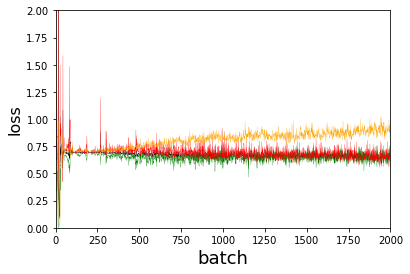

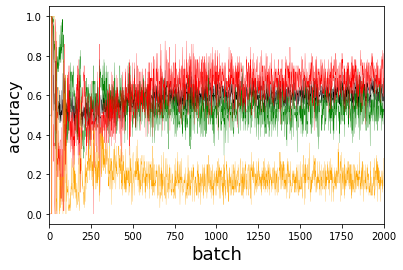

In [29]:
fig = plt.figure()
plt.plot([x[0] for x in d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in d_losses], color='red', linewidth=0.25)
plt.plot([x[0] for x in g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, 2000)
plt.ylim(0, 2)

plt.show()

fig = plt.figure()
plt.plot([x[3] for x in d_losses], color='black', linewidth=0.25)
plt.plot([x[4] for x in d_losses], color='green', linewidth=0.25)
plt.plot([x[5] for x in d_losses], color='red', linewidth=0.25)
plt.plot([x[1] for x in g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('accuracy', fontsize=16)

plt.xlim(0, 2000)

plt.show()

최종 학습된 결과를 random gaussian noise를 이용하여 생성

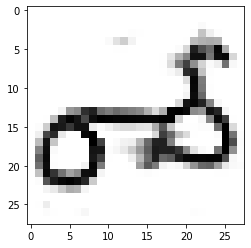

In [30]:
import numpy as np
#z_dim = 100

noise = np.random.normal(0, 1, (1, z_dim))
img = generator.predict(noise)
plt.imshow(img[0].squeeze(), cmap='binary')
plt.show()

epoch 20 생성 샘플

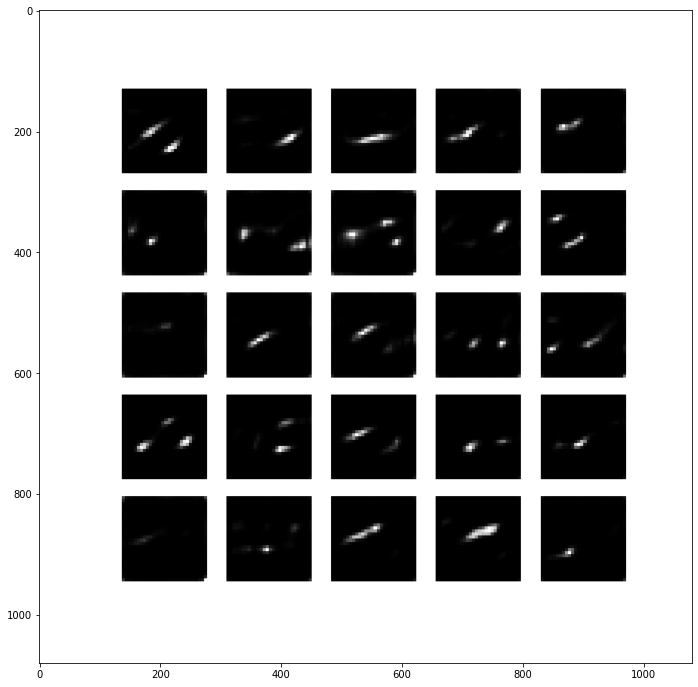

In [31]:
import matplotlib.pyplot as plt
import matplotlib.image as mp_image

image = mp_image.imread('gan_data/images/sample_%d.png' % 20)
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.show()

epoch 100 생성 샘플

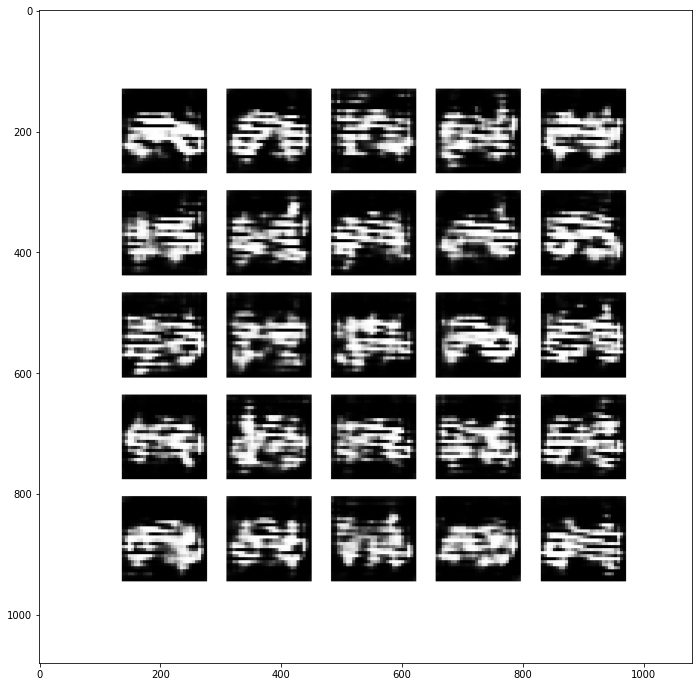

In [32]:
image = mp_image.imread('gan_data/images/sample_%d.png' % 100)
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.show()

epoch 200 생성 샘플

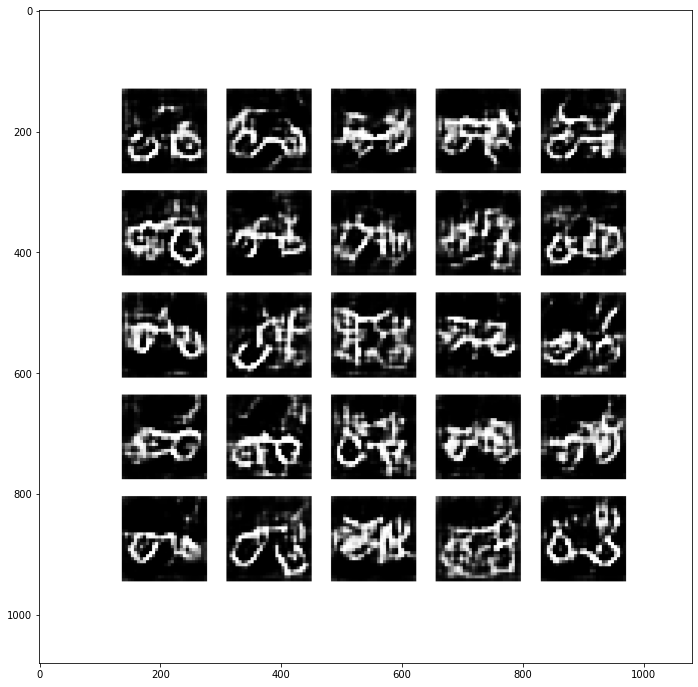

In [33]:
image = mp_image.imread('gan_data/images/sample_%d.png' % 200)
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.show()

epoch 1980 생성 샘플

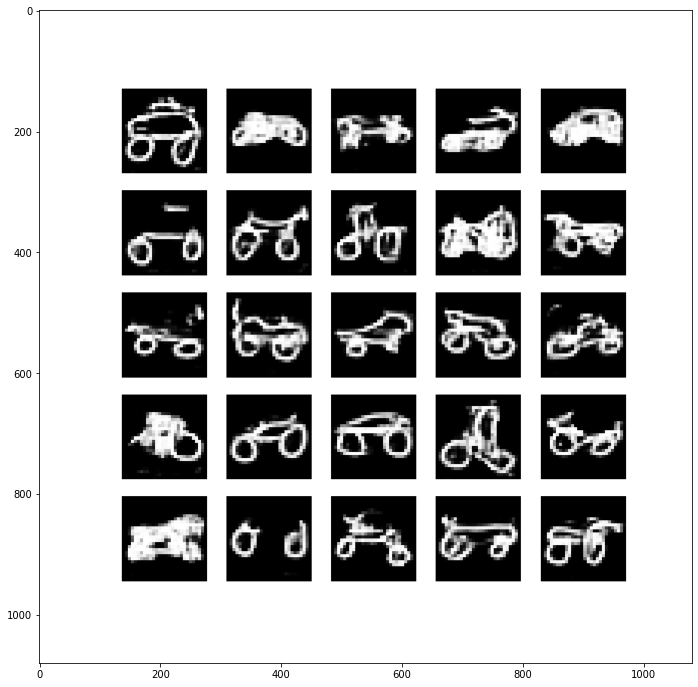

In [34]:
image = mp_image.imread('gan_data/images/sample_%d.png' % 1980)
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.show()